## 1. Introduction
As climate change becomes a critical issue in today's world, and the regulations on building energy efficiency (heating load and cooling load) become more and more strict, it is important to understand the energy consumption of buildings and have a good estimation of the energy load in the building design phase. While the traditional energy estimation solutions could be time-consuming and costly, machine learning provides an alternative approach in this area.  
In this project, I used the energy efficiency dataset from the UCI Machine Learning Repository (https://archive.ics.uci.edu/dataset/242/energy+efficiency) to build machine learning models to predict the heating and cooling loads of buildings. 

The dataset contains 768 samples of residential buildings with 8 features and 2 targets. All the buildings have the same volume but different surface areas and dimensions. The materials used for each of the 18 elements are the same for all building forms.  

Specifically:  
* `X1`	Relative Compactness  

* `X2`	Wall Area (m\(^2\))  

* `X3`	Roof Area (m\(^2\))  

* `X4`	Overall Height (m)  

* `X5`	Orientation  

* `X6`	Glazing Area (m\(^2\)). Three types of glazing areas, which are expressed as percentages of the floor area: 10%, 25%, and 40%.  

* `X7`	Glazing Area Distribution. (1) uniform: with 25% glazing on each side, (2) north: 55% on the north side and 15% on each of the other sides, (3) east: 55% on the east side and 15% on each of the other sides, (4) south: 55% on the south side and 15% on each of the other sides, and (5) west: 55% on the west side and 15% on each of the other sides.    

* `y1`	Heating Load  (kWh/m\(^2\))

* `y2`	Cooling Load  (kWh/m\(^2\))

The goal is to use the 8 features to predict each of the 2 targets.

## 2. Exploratory Data Analysis and Feature Engineering

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import seaborn as sns
import warnings
from joblib import dump
import os
from sklearn.model_selection import GridSearchCV

warnings.filterwarnings("ignore")
sns.set_theme()

In [3]:
# load data
data = pd.read_csv('/Users/jiaxinhe/Desktop/IXN/TF2DeepFloorplan/EnergyEfficiencyPrediction/ENB2012_data.csv')
data.head()

,X1,X2,X3,X4,X5,X6,X7,Y1,Y2
0,0.98,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,318.5,122.50,7.0,2,0.0,0,20.84,28.28


In [4]:
# rename columns to more informative names
data.columns = ['relative_compactness', 'wall_area', 'roof_area', 'overall_height', 'orientation', 
                'glazing_area', 'glazing_area_distribution', 'heating_load', 'cooling_load']

In [5]:
# check data type and whether there is missing value and 
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   relative_compactness       768 non-null    float64
 1   wall_area                  768 non-null    float64
 2   roof_area                  768 non-null    float64
 3   overall_height             768 non-null    float64
 4   orientation                768 non-null    int64  
 5   glazing_area               768 non-null    float64
 6   glazing_area_distribution  768 non-null    int64  
 7   heating_load               768 non-null    float64
 8   cooling_load               768 non-null    float64
dtypes: float64(7), int64(2)
memory usage: 54.1 KB


* There is no missing data.  
* As known from the dataset description, `orientation` and `glazing_area_distribution` should be categorical variables.

In [6]:
# check the distribution of these two variables to confirm
print(data['orientation'].value_counts())
print(data['glazing_area_distribution'].value_counts())

orientation
2    192
3    192
4    192
5    192
Name: count, dtype: int64
glazing_area_distribution
1    144
2    144
3    144
4    144
5    144
0     48
Name: count, dtype: int64


In [7]:
# change the data type to category
data['orientation'] = data['orientation'].astype('category')
data['glazing_area_distribution'] = data['glazing_area_distribution'].astype('category')

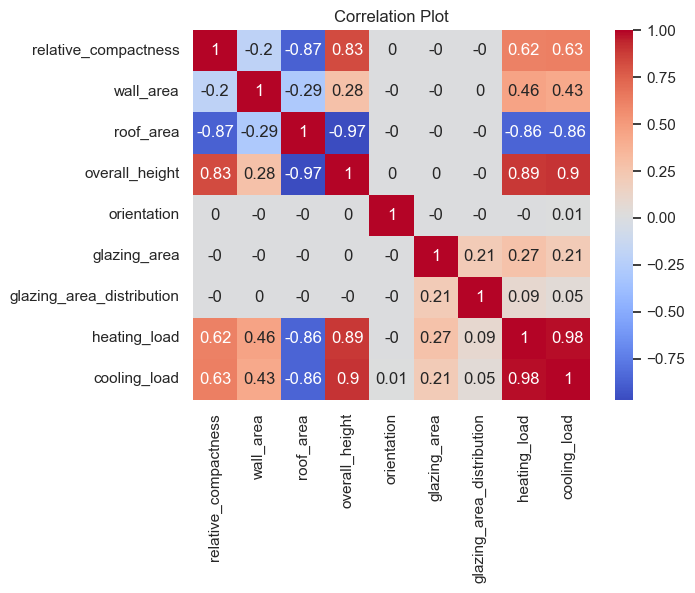

In [8]:
# check correlation between variables
corr = data.corr().round(2)
sns.heatmap(corr, cmap='coolwarm', annot=True)
plt.title('Correlation Plot')
plt.show()

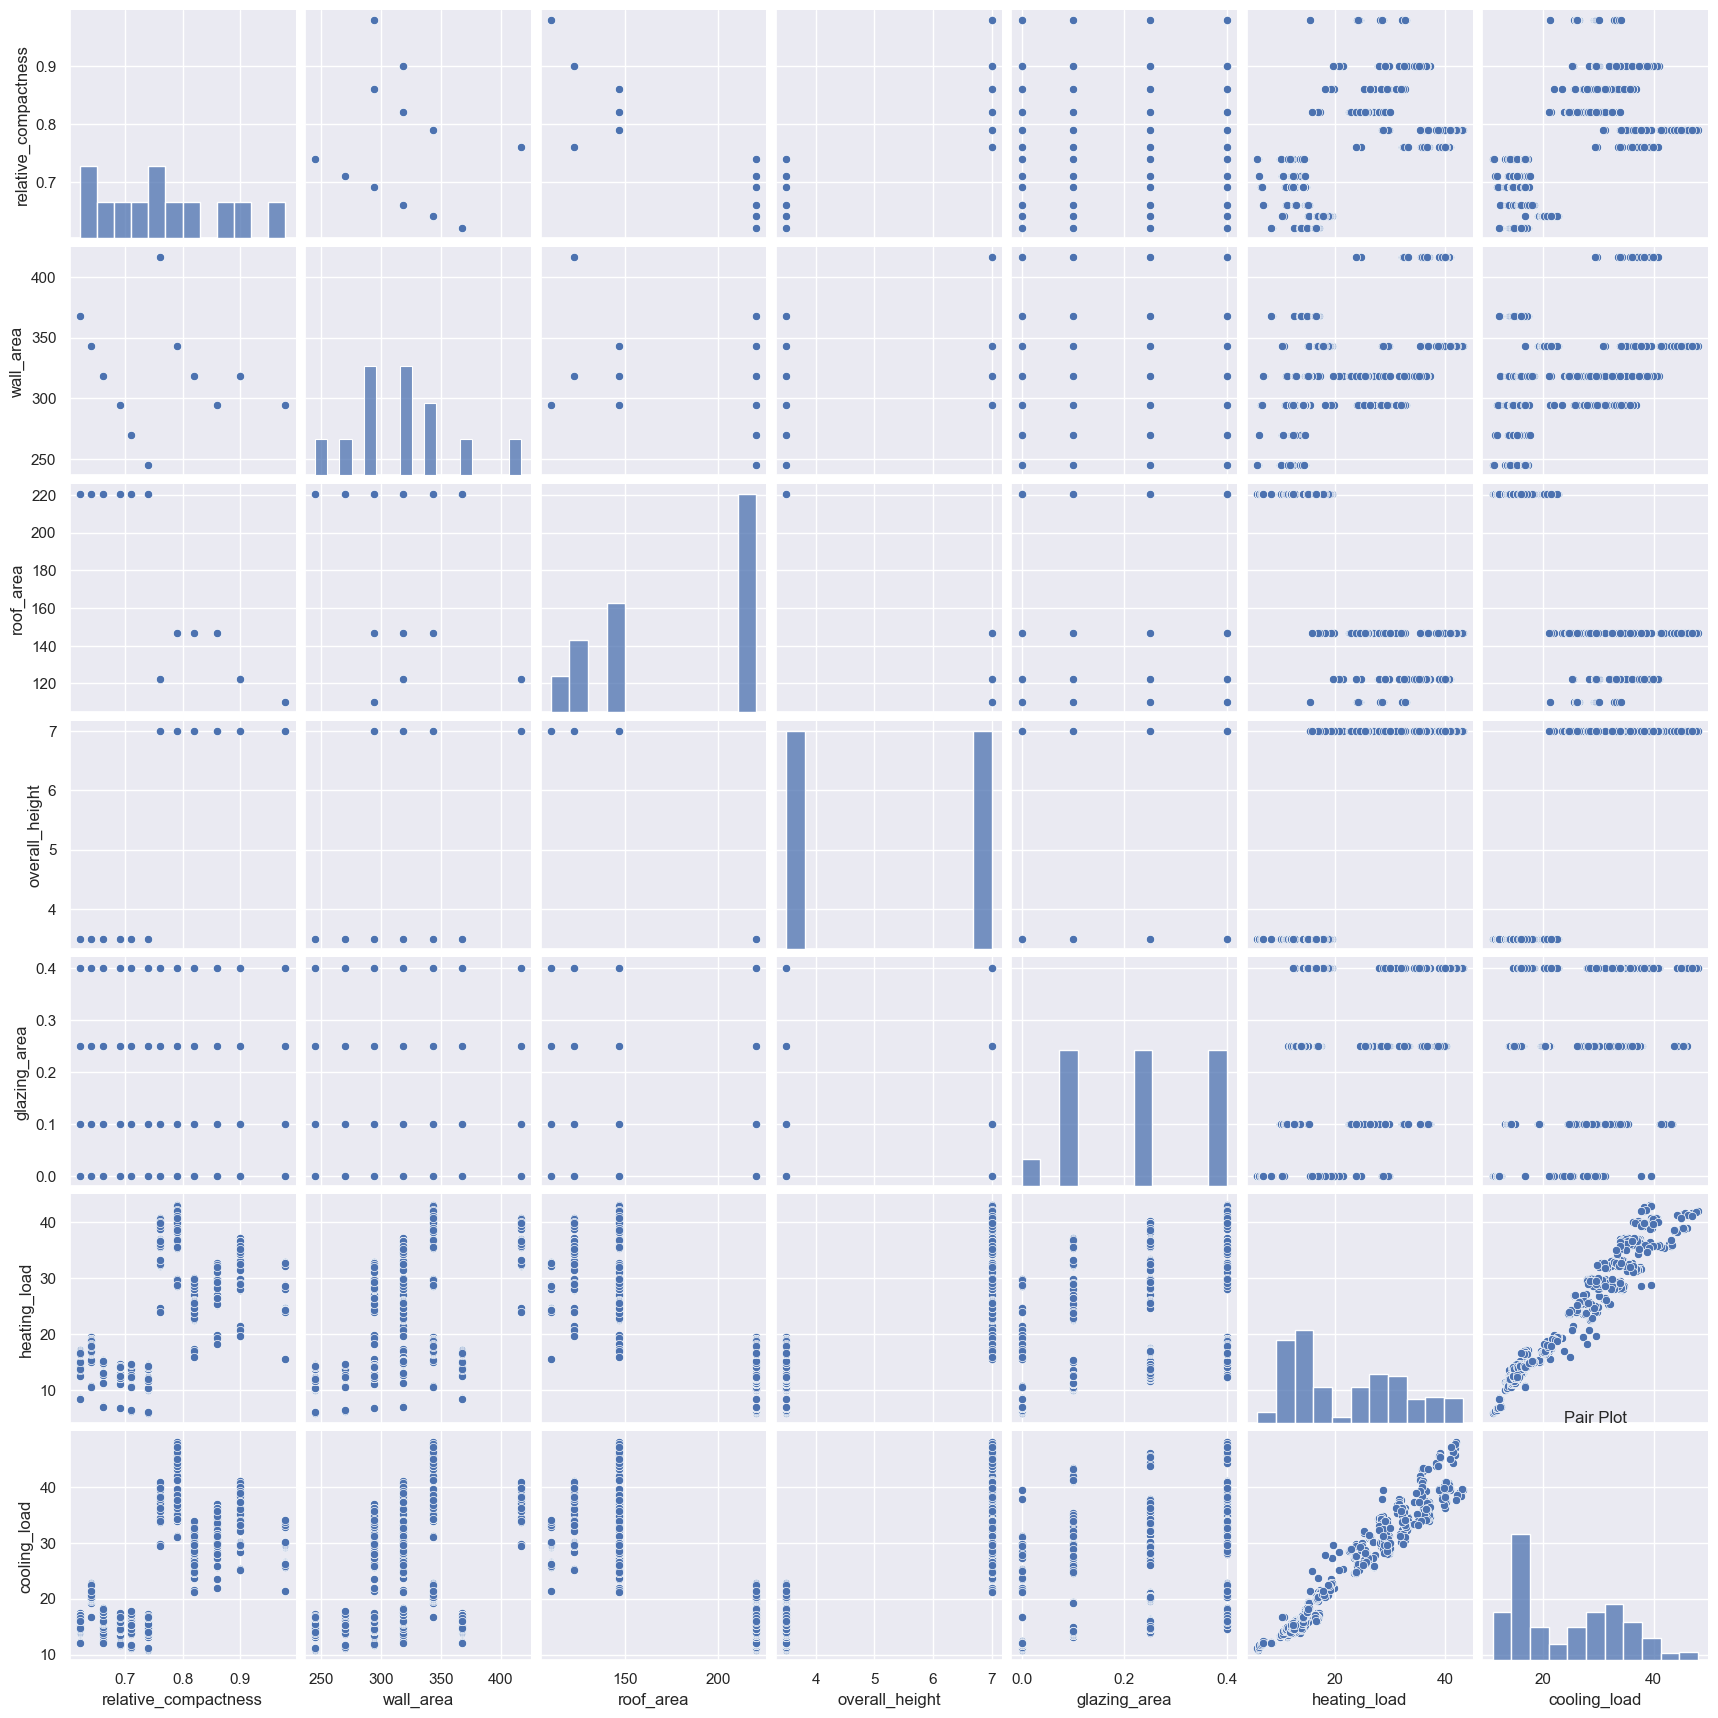

In [9]:
# check the distribution and relationship between variables
sns.pairplot(data)
plt.title('Pair Plot')
plt.show()

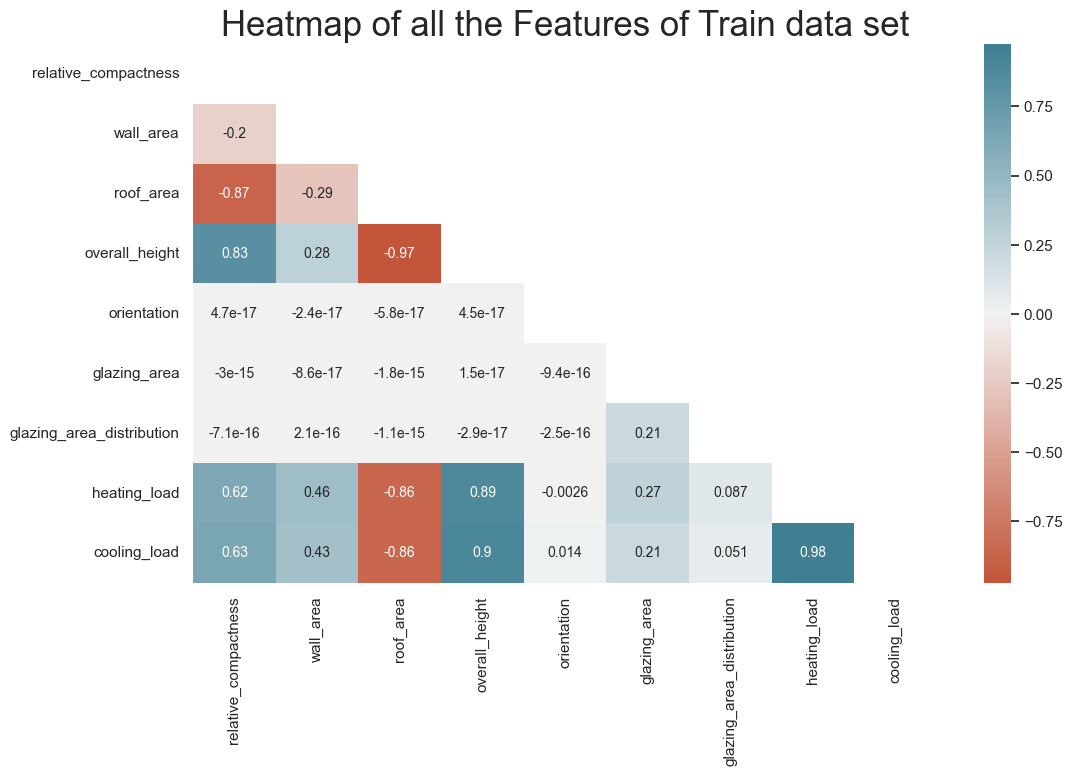

In [10]:
# To make correlation easier to understand we can use correlation matrix
# Use 'ggplot' style for other plots
plt.style.use('ggplot')

# Temporarily change to 'white' style to remove the grid for the heatmap
sns.set_style('white')

# Create the plot
plt.subplots(figsize=(12, 7))

# Generate a mask for the upper triangle
mask = np.zeros_like(data.corr(), dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Plotting the heatmap
sns.heatmap(
    data.corr(),
    cmap=sns.diverging_palette(20, 220, n=200),
    annot=True,
    mask=mask,
    center=0
)

# Set the title
plt.title("Heatmap of all the Features of Train data set", fontsize=25)

# Optionally revert to the previous style
sns.set_style('whitegrid')  # Or set to 'ggplot' or other styles as needed

# Show the plot
plt.show()

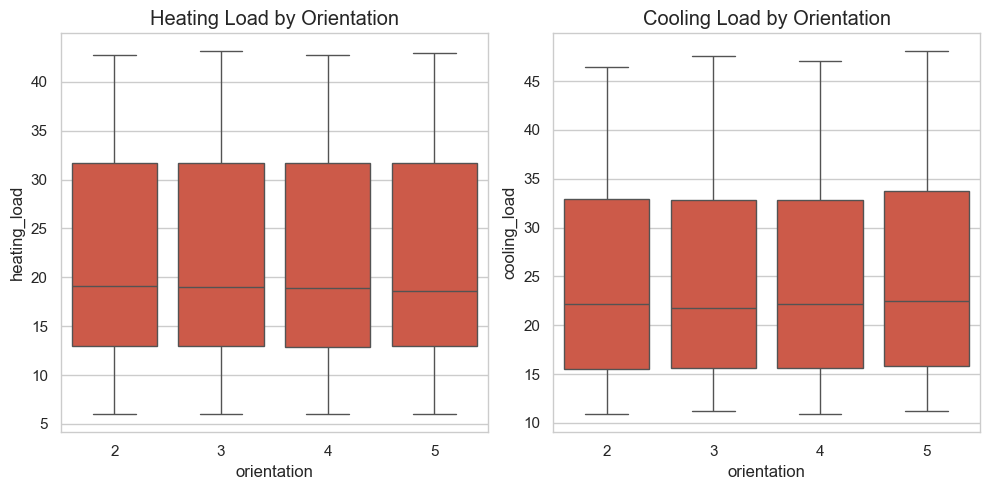

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# check whether orientation has an impact on heating_load
sns.boxplot(data=data, x='orientation', y='heating_load', ax=axes[0])
axes[0].set_title('Heating Load by Orientation')

# check whether orientation has an impact on cooling_load
sns.boxplot(data=data, x='orientation', y='cooling_load', ax=axes[1])
axes[1].set_title('Cooling Load by Orientation')

plt.tight_layout()
plt.show()

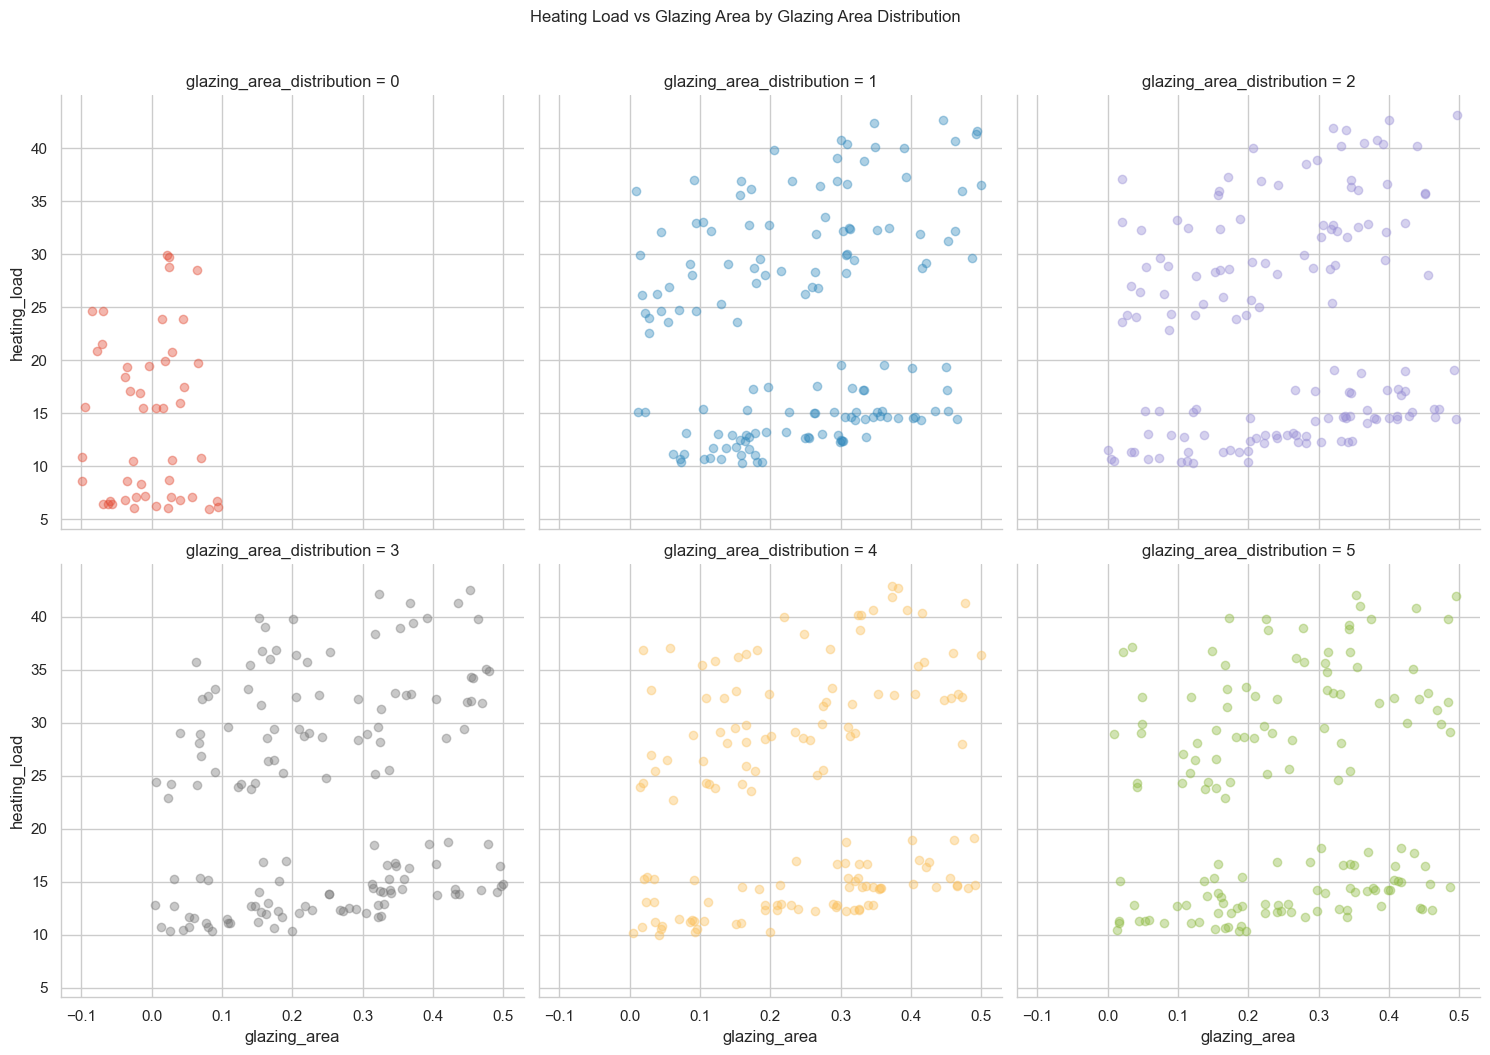

In [12]:
# check whether the glazing_area_distribution has an impact on the relationship between glazing_are and heating_load
lmplot = sns.lmplot(data=data, x='glazing_area', y='heating_load', hue='glazing_area_distribution', 
           fit_reg=False, scatter_kws={'alpha':0.4}, x_jitter=0.1, y_jitter=0.1,
           col='glazing_area_distribution', col_wrap=3)
lmplot.fig.suptitle('Heating Load vs Glazing Area by Glazing Area Distribution', y=1.05)
plt.show()



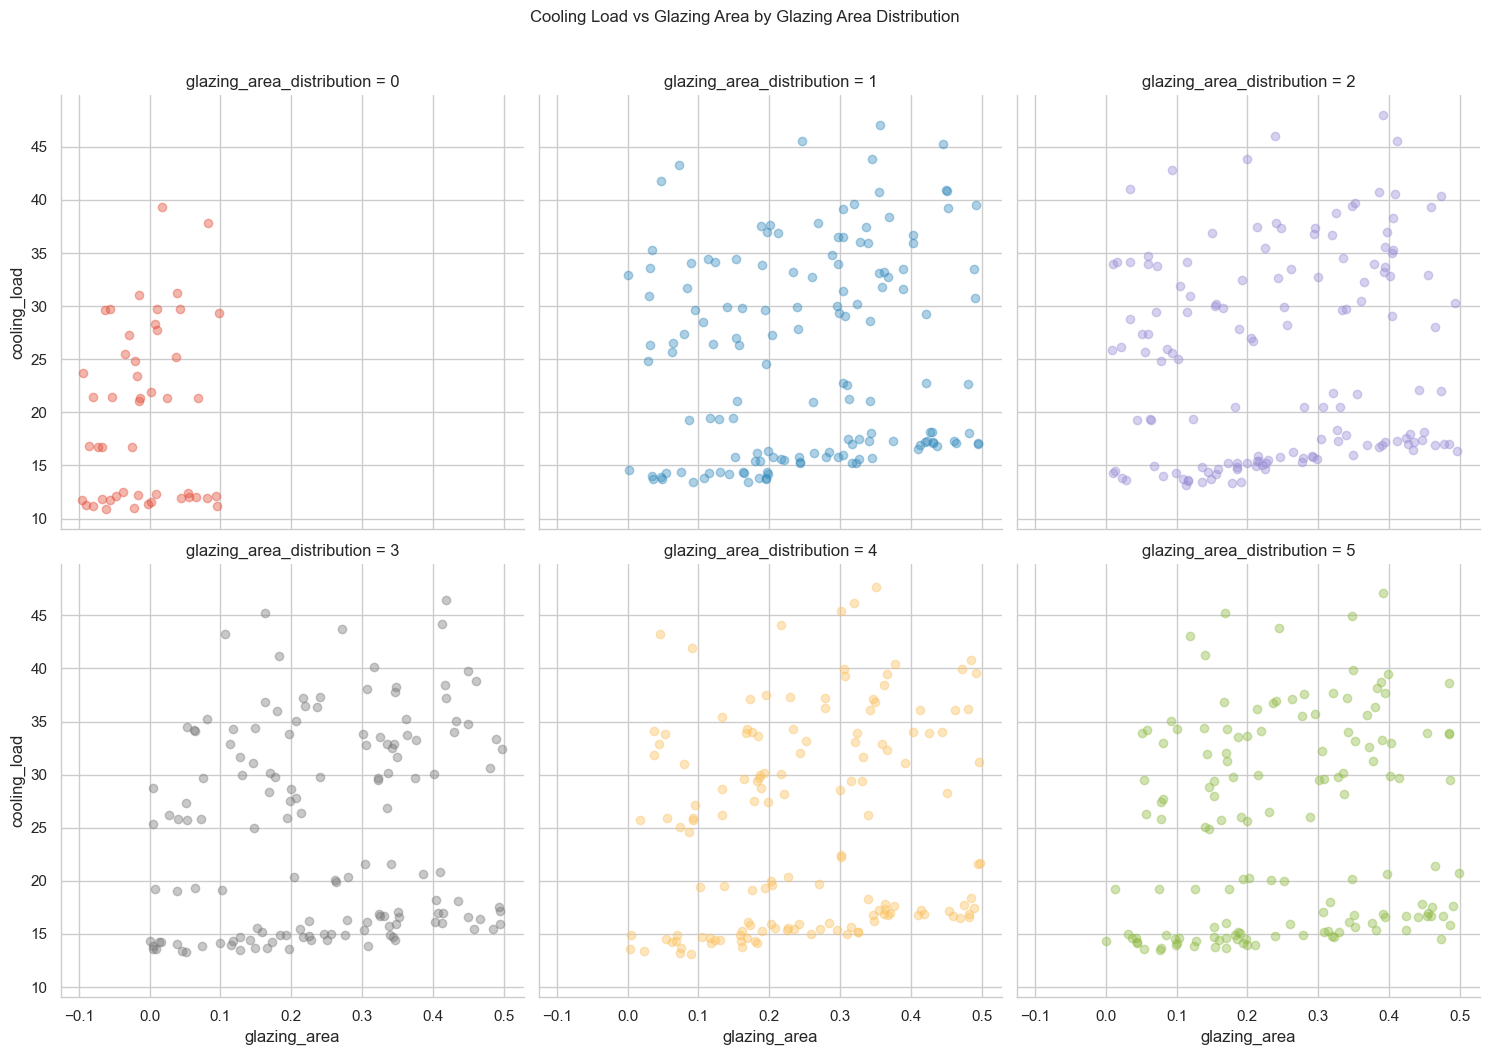

In [13]:
# check whether the glazing_area_distribution has an impact on the relationship between glazing_are and cooling_load
lmplot = sns.lmplot(data=data, x='glazing_area', y='cooling_load', hue='glazing_area_distribution', 
           fit_reg=False, scatter_kws={'alpha':0.4}, x_jitter=0.1, y_jitter=0.1,
           col='glazing_area_distribution', col_wrap=3)
lmplot.fig.suptitle('Cooling Load vs Glazing Area by Glazing Area Distribution', y=1.05)
plt.show()

* Except type 0, different types of `glazing_area_distribution` scatter similarly.

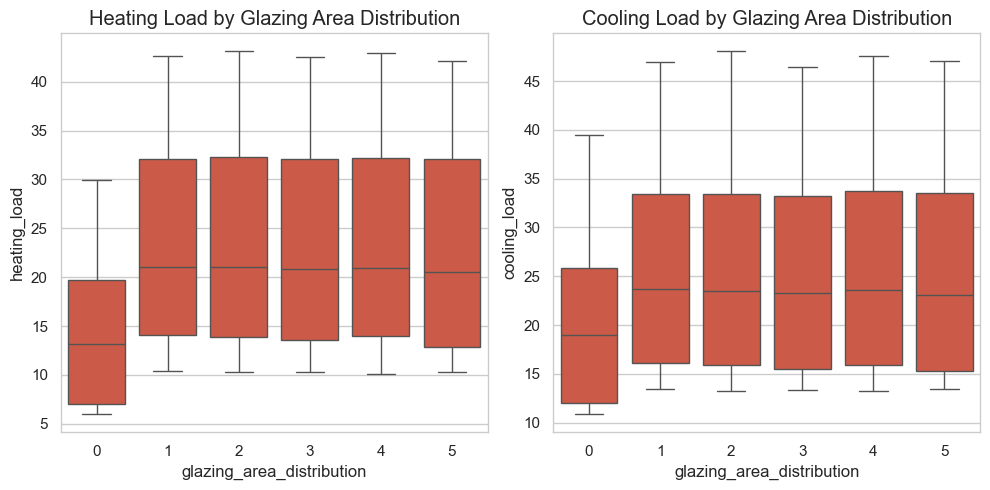

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# check whether glazing_area_distribution has an impact on heating_load
sns.boxplot(data=data, x='glazing_area_distribution', y='heating_load', ax=axes[0])
axes[0].set_title('Heating Load by Glazing Area Distribution')

# check whether glazing_area_distribution has an impact on cooling_load
sns.boxplot(data=data, x='glazing_area_distribution', y='cooling_load', ax=axes[1])
axes[1].set_title('Cooling Load by Glazing Area Distribution')

plt.tight_layout()
plt.show()

* Only type 0 of `glazing_area_distribution` has an significant impact on the heating and cooling load, so I can use binarization to reduce dimensionality.

In [15]:
# change glazing_area_distribution to binary variable to reduce dimensionality
data['glazing_area_distribution'] = data['glazing_area_distribution'].replace({0:0, 1:1, 2:1, 3:1, 4:1, 5:1})
data['glazing_area_distribution'] = data['glazing_area_distribution'].astype('category')
data['glazing_area_distribution'].value_counts()

glazing_area_distribution
1    720
0     48
Name: count, dtype: int64

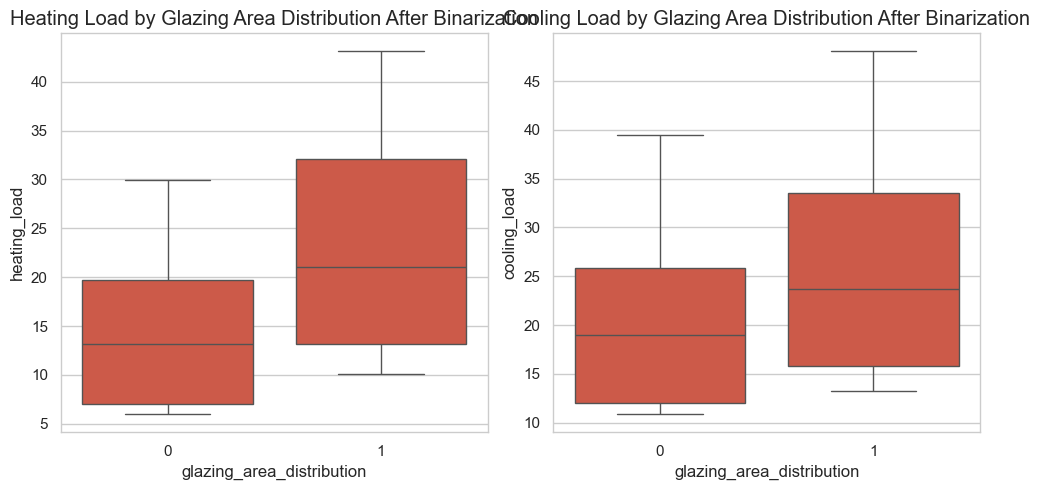

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# check whether glazing_area_distribution has an impact on heating_load
sns.boxplot(data=data, x='glazing_area_distribution', y='heating_load', ax=axes[0])
axes[0].set_title('Heating Load by Glazing Area Distribution After Binarization')

# check whether glazing_area_distribution has an impact on cooling_load
sns.boxplot(data=data, x='glazing_area_distribution', y='cooling_load', ax=axes[1])
axes[1].set_title('Cooling Load by Glazing Area Distribution After Binarization')

plt.tight_layout()
plt.show()

In [17]:
# splitting the dataset into features and targets
y1 = data['heating_load']
y2 = data['cooling_load']
X = data.drop(['heating_load','cooling_load'], axis = 1)

# check features
features = list(X.columns)
features

['relative_compactness',
 'wall_area',
 'roof_area',
 'overall_height',
 'orientation',
 'glazing_area',
 'glazing_area_distribution']

## 3. Linear Regression Model

Next, I will try the classic OLS linear regression model and see how it performs.

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
seed = 1

In [19]:
# split the dataset into training and testing sets
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size = 0.30, random_state=seed)
X_train, X_test, y2_train, y2_test = train_test_split(X, y2, test_size = 0.30, random_state=seed)

# standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [20]:

# Train the model and make predictions for heating_load
lr_heating = LinearRegression()
y1_pred = lr_heating.fit(X_train, y1_train).predict(X_test)


# Train the model and make predictions for cooling_load
lr_cooling = LinearRegression()
y2_pred = lr_cooling.fit(X_train, y2_train).predict(X_test)


# calculate the adjusted R2 score
adjuted_r2_heating = 1 - (1-r2_score(y1_test, y1_pred))*(len(y1_test)-1)/(len(y1_test)-X_test.shape[1]-1)
adjuted_r2_cooling = 1 - (1-r2_score(y2_test, y2_pred))*(len(y2_test)-1)/(len(y2_test)-X_test.shape[1]-1)
print('Heating load model adjusted R2 score: \n', adjuted_r2_heating.round(4))
print('Cooling load model adjusted R2 score: \n', adjuted_r2_cooling.round(4))
print('')

# calculate the MSE
print('MSE of predicting heating load: \n', mean_squared_error(y1_test, y1_pred).round(4))
print('MSE of predicting cooling load: \n', mean_squared_error(y2_test, y2_pred).round(4))
print('')

# calculate the RMSE
print('RMSE of predicting heating load: \n', mean_squared_error(y1_test, y1_pred, squared=False).round(4))
print('RMSE of predicting cooling load: \n', mean_squared_error(y2_test, y2_pred, squared=False).round(4))
print('')

# calculate the MAE
print('MAE of predicting heating load: \n', mean_absolute_error(y1_test, y1_pred).round(4))
print('MAE of predicting cooling load: \n', mean_absolute_error(y2_test, y2_pred).round(4))

Heating load model adjusted R2 score: 
 0.8998
Cooling load model adjusted R2 score: 
 0.8606

MSE of predicting heating load: 
 9.9062
MSE of predicting cooling load: 
 12.3233

RMSE of predicting heating load: 
 3.1474
RMSE of predicting cooling load: 
 3.5105

MAE of predicting heating load: 
 2.3021
MAE of predicting cooling load: 
 2.5153


#### Interpretation of the Prediction Results

* The adjusted R squared of the heating load model and the cooling load model are 0.9003 and 0.8623 respectively, indicating that the model can explain 90.03% and 86.23% of the differences in the energy efficiency of different buildings, respectively. The models show good fits to the data and could be useful in predicting the energy efficiency based on the 6 metrics of a residential building.  

* The MAE(Mean Absolute Error) of the fitted models are 2.3002 and 2.4978 respectively, meaning that the predicted values of energy efficiency would deviate from the actual values by an average of 2.3002 and 2.4978 units respectively. This metric shows the expected error when making predictions using the fitted models and the 6 features, and allows us to determine if the error is acceptable in the use case.  

* The MSE(Mean Squared Error) is 9.8933 and 12.2353 respectively. This metric is larger than the MAE because it penalizes large errors by squaring each error. It could be useful when comparing the performance of different models because MSE can show the instability of the prediction performance of different models.  

* The RMSE(Root Mean Squared Error) is 3.1454 and 3.4979 respectively. This metric takes the square root of the mean squared error to make the unit of the RMSE the same as the unit of the target variable, which is energy efficiency in this case, so it could be better interpreted in the context of the use case and by people without statistical background. It's still larger than MAE because it penalizes large errors.

After evaluating the performance of the model, I check the feature importance to see which features of a residential building contribute most to the energy efficiency.

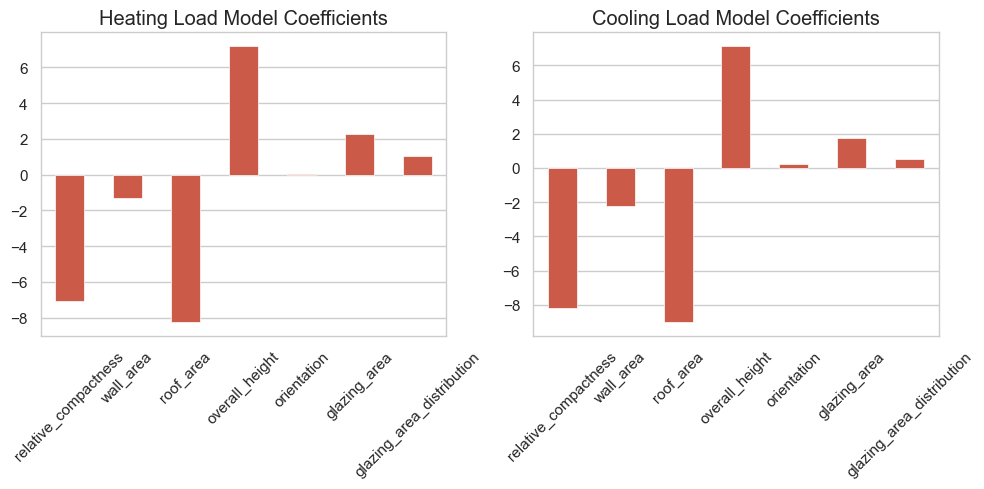

In [21]:
# plot the coefficients of features
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.barplot(x=features, y=lr_heating.coef_, width=0.5, ax=axes[0])
axes[0].set_title('Heating Load Model Coefficients')
axes[0].set_xticklabels(labels=features, rotation=45)

sns.barplot(x=features, y=lr_cooling.coef_, width=0.5, ax=axes[1])
axes[1].set_title('Cooling Load Model Coefficients')
axes[1].set_xticklabels(labels=features, rotation=45)

plt.tight_layout()
plt.show()

* The `relative_compactness` and `roof_area` have significant negative impact on both heating load and cooling load.
* The `overall_height` has significant positive impact on both heating load and cooling load.
* These three features have the greatest impact on energy efficiency.

In [22]:
# check the coefficients and intercepts of the models
print('Heating load model coefficients:')
for i in range(len(features)):
    print(features[i], ':', lr_heating.coef_[i])
print('Heating load model intercept: \n', lr_heating.intercept_)
print('')

print('Cooling load model coefficients:')
for i in range(len(features)):
    print(features[i], ':', lr_cooling.coef_[i])
print('Cooling load model intercept: \n', lr_cooling.intercept_)

Heating load model coefficients:
relative_compactness : -7.096056199089214
wall_area : -1.316586655509779
roof_area : -8.237492419260391
overall_height : 7.18114294701982
orientation : 0.034103137911642545
glazing_area : 2.242966268137125
glazing_area_distribution : 1.0198897613973381
Heating load model intercept: 
 21.914413407821232

Cooling load model coefficients:
relative_compactness : -8.15708234573076
wall_area : -2.231381173746616
roof_area : -8.987894377198945
overall_height : 7.117692473258431
orientation : 0.22816925640114047
glazing_area : 1.7627150990113647
glazing_area_distribution : 0.507132052185072
Cooling load model intercept: 
 24.170484171322162


## 4. Model Selection

* The pairplot above shows that there are not much linear relationship between the features and the target variables, and the variables are not normally distributed, so a linear regression model may not be the best choice for this dataset.  
* Next, I will try different types of models to see if there is a better model for predicting energy efficiency. 
* Since the dataset only contains 768 samples, it's possible to use Leave-One-Out (LOO) as the cross-validation method.

In [23]:
from sklearn.linear_model import Ridge, Lasso   
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.model_selection import LeaveOneOut


In [24]:
# define various models and make a list
models = [LinearRegression(), Ridge(random_state=seed), Lasso(random_state=seed), 
          DecisionTreeRegressor(random_state=seed), RandomForestRegressor(random_state=seed), 
          GradientBoostingRegressor(random_state=seed), AdaBoostRegressor(random_state=seed), 
          KNeighborsRegressor(), SVR()]

In [25]:
# standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [26]:
# define a function using leave-one-out cross validation to evaluate the models
def loo_results(model, X_scaled, y):
    
    loo = LeaveOneOut()
    test_array = np.array([])
    pred_array = np.array([])
    
    for train_index, test_index in loo.split(X_scaled):
        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]
        y_pred = model.fit(X_train, y_train).predict(X_test)
        test_array = np.append(test_array, y_test)
        pred_array = np.append(pred_array, y_pred)
    
    r2 = r2_score(test_array, pred_array)
    adjusted_r2 = (1 - (1-r2)*(len(test_array)-1)/(len(test_array)-X_scaled.shape[1]-1))
    mse = mean_squared_error(test_array, pred_array)
    rmse = mean_squared_error(test_array, pred_array, squared=False)
    mae = mean_absolute_error(test_array, pred_array)
    
    return adjusted_r2, mse, rmse, mae

In [27]:
# create ataframes to store the results
df_loo_heating = pd.DataFrame(columns=['Model_Heating', 'LOO_Adj_R2', 'LOO_MSE', 'LOO_RMSE', 'LOO_MAE'])
df_loo_cooling = pd.DataFrame(columns=['Model_Cooling', 'LOO_Adj_R2', 'LOO_MSE', 'LOO_RMSE', 'LOO_MAE'])

for model in models:
    adjuted_r2_heating, mse_heating, rmse_heating, mae_heating = loo_results(model, X_scaled, y1)
    df_loo_heating = pd.concat([df_loo_heating, 
                                pd.DataFrame([[model.__class__.__name__, 
                                               adjuted_r2_heating, mse_heating, mae_heating, rmse_heating]],
                                             columns=['Model_Heating', 'LOO_Adj_R2', 'LOO_MSE', 'LOO_RMSE', 'LOO_MAE'])],
                                axis=0)
    adjuted_r2_cooling, mse_cooling, rmse_cooling, mae_cooling = loo_results(model, X_scaled, y2)
    df_loo_cooling = pd.concat([df_loo_cooling,
                                pd.DataFrame([[model.__class__.__name__,
                                               adjuted_r2_cooling, mse_cooling, mae_cooling, rmse_cooling]],
                                             columns=['Model_Cooling', 'LOO_Adj_R2', 'LOO_MSE', 'LOO_RMSE', 'LOO_MAE'])],
                                axis=0)
    
# sort the results by adjusted R2
df_loo_heating = df_loo_heating.sort_values(by='LOO_Adj_R2', ascending=False).reset_index(drop=True)
df_loo_cooling = df_loo_cooling.sort_values(by='LOO_Adj_R2', ascending=False).reset_index(drop=True)

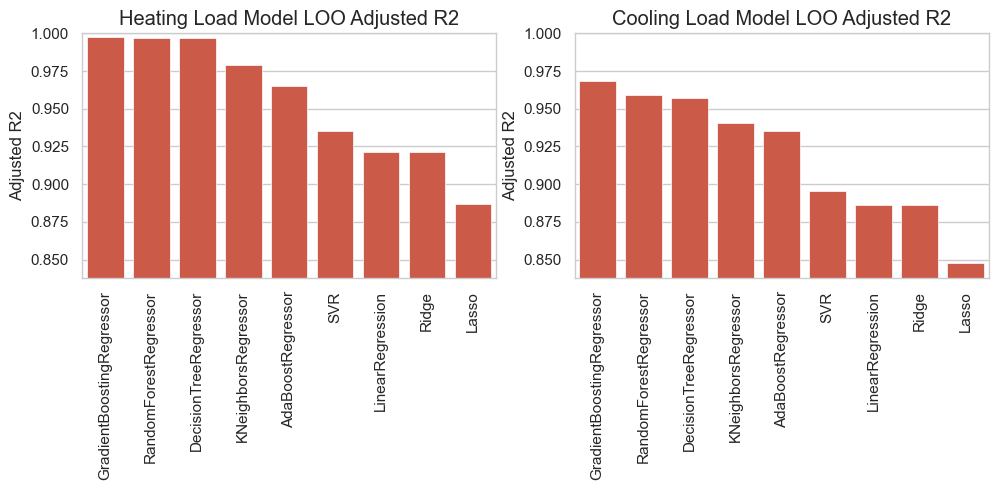

In [29]:
# # plot the results of cross validation
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# sns.lineplot(data=df_loo_heating, x='Model_Heating', y='LOO_Adj_R2', label='Adjusted R2', ax=ax[0])
# ax[0].set_xticklabels(labels=df_loo_heating['Model_Heating'], rotation=90)
# ax[0].set_xlabel('')
# ax[0].set_ylabel('')
# ax[0].set_title('Heating Load Model LOO Adjusted R2')

# sns.lineplot(data=df_loo_cooling, x='Model_Cooling', y='LOO_Adj_R2', label='Adjusted R2', ax=ax[1])
# ax[1].set_xticklabels(labels=df_loo_cooling['Model_Cooling'], rotation=90)
# ax[1].set_xlabel('')
# ax[1].set_ylabel('')
# ax[1].set_title('Cooling Load Model LOO Adjusted R2')

# plt.tight_layout()
# plt.show()


# Find the minimum value of R2 in both datasets to set the y-axis limit
min_r2 = min(df_loo_heating['LOO_Adj_R2'].min(), df_loo_cooling['LOO_Adj_R2'].min())

# Plot the results of cross-validation using bar charts
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Heating Load Model
sns.barplot(data=df_loo_heating, x='Model_Heating', y='LOO_Adj_R2', ax=ax[0])
ax[0].set_xticklabels(labels=df_loo_heating['Model_Heating'], rotation=90)
ax[0].set_ylim(min_r2 - 0.01, 1.0)  # Adjust y-axis to start just below the min R2 value
ax[0].set_xlabel('')
ax[0].set_ylabel('Adjusted R2')
ax[0].set_title('Heating Load Model LOO Adjusted R2')

# Cooling Load Model
sns.barplot(data=df_loo_cooling, x='Model_Cooling', y='LOO_Adj_R2', ax=ax[1])
ax[1].set_xticklabels(labels=df_loo_cooling['Model_Cooling'], rotation=90)
ax[1].set_ylim(min_r2 - 0.01, 1.0)  # Adjust y-axis to start just below the min R2 value
ax[1].set_xlabel('')
ax[1].set_ylabel('Adjusted R2')
ax[1].set_title('Cooling Load Model LOO Adjusted R2')

plt.tight_layout()
plt.show()

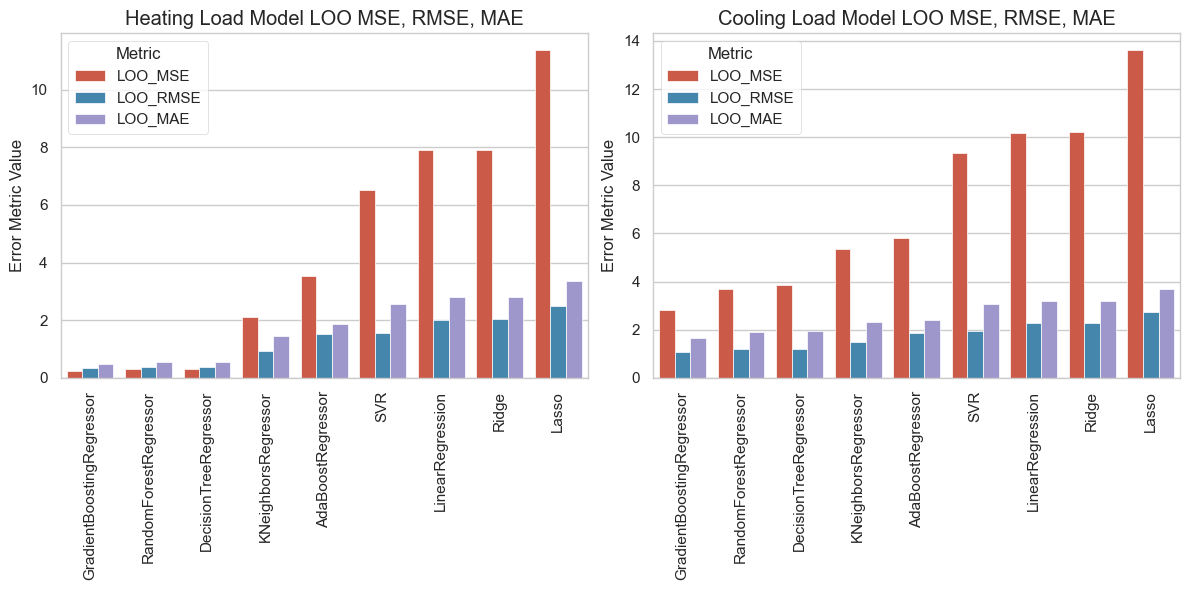

In [30]:
# # plot the results of cross validation
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# sns.lineplot(data=df_loo_heating, x='Model_Heating', y='LOO_MSE', label='MSE', ax=ax[0])
# sns.lineplot(data=df_loo_heating, x='Model_Heating', y='LOO_RMSE', label='RMSE', ax=ax[0])
# sns.lineplot(data=df_loo_heating, x='Model_Heating', y='LOO_MAE', label='MAE', ax=ax[0])
# ax[0].set_xticklabels(labels=df_loo_heating['Model_Heating'], rotation=90)
# ax[0].set_xlabel('')
# ax[0].set_ylabel('')
# ax[0].set_title('Heating Load Model LOO MSE, RMSE, MAE')

# sns.lineplot(data=df_loo_cooling, x='Model_Cooling', y='LOO_MSE', label='MSE', ax=ax[1])
# sns.lineplot(data=df_loo_cooling, x='Model_Cooling', y='LOO_RMSE', label='RMSE', ax=ax[1])
# sns.lineplot(data=df_loo_cooling, x='Model_Cooling', y='LOO_MAE', label='MAE', ax=ax[1])
# ax[1].set_xlabel('')
# ax[1].set_ylabel('')
# ax[1].set_xticklabels(labels=df_loo_cooling['Model_Cooling'], rotation=90)
# ax[1].set_title('Cooling Load Model LOO MSE, RMSE, MAE')

# plt.tight_layout()
# plt.show()

# Melt the data into long format for easier plotting with barplot
df_loo_heating_melted = df_loo_heating.melt(id_vars='Model_Heating', value_vars=['LOO_MSE', 'LOO_RMSE', 'LOO_MAE'], 
                                            var_name='Metric', value_name='Value')
df_loo_cooling_melted = df_loo_cooling.melt(id_vars='Model_Cooling', value_vars=['LOO_MSE', 'LOO_RMSE', 'LOO_MAE'], 
                                            var_name='Metric', value_name='Value')

# Plot the results using bar charts
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Heating Load Model
sns.barplot(data=df_loo_heating_melted, x='Model_Heating', y='Value', hue='Metric', ax=ax[0])
ax[0].set_xticklabels(labels=df_loo_heating['Model_Heating'], rotation=90)
ax[0].set_xlabel('')
ax[0].set_ylabel('Error Metric Value')
ax[0].set_title('Heating Load Model LOO MSE, RMSE, MAE')

# Cooling Load Model
sns.barplot(data=df_loo_cooling_melted, x='Model_Cooling', y='Value', hue='Metric', ax=ax[1])
ax[1].set_xticklabels(labels=df_loo_cooling['Model_Cooling'], rotation=90)
ax[1].set_xlabel('')
ax[1].set_ylabel('Error Metric Value')
ax[1].set_title('Cooling Load Model LOO MSE, RMSE, MAE')

plt.tight_layout()
plt.show()

In [29]:
# check the results
print(df_loo_heating.round(4))
print('')
print(df_loo_cooling.round(4))

               Model_Heating  LOO_Adj_R2  LOO_MSE  LOO_RMSE  LOO_MAE
0  GradientBoostingRegressor      0.9976   0.2376    0.3502   0.4875
1      RandomForestRegressor      0.9970   0.3026    0.3903   0.5501
2      DecisionTreeRegressor      0.9970   0.3057    0.3921   0.5529
3        KNeighborsRegressor      0.9790   2.1134    0.9376   1.4538
4          AdaBoostRegressor      0.9650   3.5267    1.5071   1.8780
5                        SVR      0.9354   6.5038    1.5735   2.5503
6           LinearRegression      0.9216   7.8988    2.0244   2.8105
7                      Ridge      0.9214   7.9173    2.0357   2.8138
8                      Lasso      0.8870  11.3856    2.4801   3.3743

               Model_Cooling  LOO_Adj_R2  LOO_MSE  LOO_RMSE  LOO_MAE
0  GradientBoostingRegressor      0.9686   2.8163    1.0776   1.6782
1      RandomForestRegressor      0.9589   3.6776    1.2049   1.9177
2      DecisionTreeRegressor      0.9571   3.8429    1.2162   1.9603
3        KNeighborsRegressor     

## 5. Model Validation

* Comparing to the linear regression model, Gradient Boosting, Decision Tree, Random Forest and K-Nearest Neighbors have significant improvements in the cross-validation model performance.
* Next, I will test these 4 models to see which model performs best on an unseen dataset.

In [31]:
# split the data into training and testing sets
X_train, X_test, y1_train, y1_test, y2_train, y2_test = train_test_split(X, y1, y2, test_size=0.2, random_state=seed)

# scale the data
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [32]:
# define a function to evaluate the models using test data
def model_test(model, X_train, y_train, X_test, y_test):
    
    y_pred = model.fit(X_train, y_train).predict(X_test)
    
    # calculate the evaluation metrics
    r2 = r2_score(y_test, y_pred)
    adjusted_r2 = (1 - (1-r2)*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1))
    mse = mean_squared_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    mae = mean_absolute_error(y_test, y_pred)
    
    return adjusted_r2, mse, rmse, mae

In [33]:
# define the models to be tested
models_test = [ DecisionTreeRegressor(random_state=seed), RandomForestRegressor(random_state=seed),
                GradientBoostingRegressor(random_state=seed), KNeighborsRegressor()]

In [34]:
# create dataframes to store the evaluation metrics of models
df_heating_test = pd.DataFrame(columns=['Model_Heating', 'Test_Adj_R2', 'Test_MSE', 'Test_RMSE', 'Test_MAE'])
for model in models_test:
    adjusted_r2, mse, rmse, mae = model_test(model, X_train, y1_train, X_test, y1_test)
    df_heating_test = pd.concat([df_heating_test, 
                                 pd.DataFrame([[model.__class__.__name__, adjusted_r2, mse, rmse, mae]], 
                                              columns=['Model_Heating', 'Test_Adj_R2', 'Test_MSE', 'Test_RMSE', 'Test_MAE'])], 
                                axis=0)
df_heating_test = df_heating_test.sort_values(by='Test_Adj_R2', ascending=False).reset_index(drop=True)


df_cooling_test = pd.DataFrame(columns=['Model_Cooling', 'Test_Adj_R2', 'Test_MSE', 'Test_RMSE', 'Test_MAE'])
for model in models_test:
    adjusted_r2, mse, rmse, mae = model_test(model, X_train, y2_train, X_test, y2_test)
    df_cooling_test = pd.concat([df_cooling_test, 
                                 pd.DataFrame([[model.__class__.__name__, adjusted_r2, mse, rmse, mae]], 
                                              columns=['Model_Cooling', 'Test_Adj_R2', 'Test_MSE', 'Test_RMSE', 'Test_MAE'])], 
                                axis=0)
df_cooling_test = df_cooling_test.sort_values(by='Test_Adj_R2', ascending=False).reset_index(drop=True)

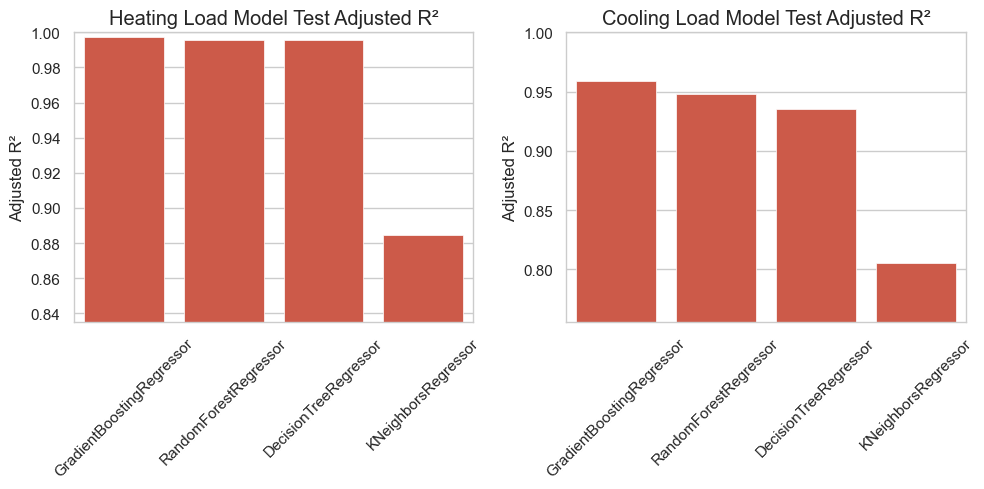

In [38]:
# # plot the results of test data
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# sns.lineplot(data=df_heating_test, x='Model_Heating', y='Test_Adj_R2', label='Adjusted R2', ax=ax[0])
# ax[0].set_xticklabels(labels=df_heating_test['Model_Heating'], rotation=45)
# ax[0].set_xlabel('')
# ax[0].set_ylabel('')
# ax[0].set_title('Heating Load Model Test Adjusted R2')

# sns.lineplot(data=df_cooling_test, x='Model_Cooling', y='Test_Adj_R2', label='Adjusted R2', ax=ax[1])
# ax[1].set_xlabel('')
# ax[1].set_ylabel('')
# ax[1].set_xticklabels(labels=df_cooling_test['Model_Cooling'], rotation=45)
# ax[1].set_title('Cooling Load Model Test Adjusted R2')

# plt.tight_layout()
# plt.show()

# Plot the Adjusted R² for Test Data using bar charts
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Heating Load Model Test Adjusted R²
sns.barplot(data=df_heating_test, x='Model_Heating', y='Test_Adj_R2', ax=ax[0])
ax[0].set_xticklabels(labels=df_heating_test['Model_Heating'], rotation=45)
ax[0].set_ylim(df_heating_test['Test_Adj_R2'].min() - 0.05, 1.0)  # Adjust y-axis limits
ax[0].set_xlabel('')
ax[0].set_ylabel('Adjusted R²')
ax[0].set_title('Heating Load Model Test Adjusted R²')

# Cooling Load Model Test Adjusted R²
sns.barplot(data=df_cooling_test, x='Model_Cooling', y='Test_Adj_R2', ax=ax[1])
ax[1].set_xticklabels(labels=df_cooling_test['Model_Cooling'], rotation=45)
ax[1].set_ylim(df_cooling_test['Test_Adj_R2'].min() - 0.05, 1.0)  # Adjust y-axis limits
ax[1].set_xlabel('')
ax[1].set_ylabel('Adjusted R²')
ax[1].set_title('Cooling Load Model Test Adjusted R²')

plt.tight_layout()
plt.show()


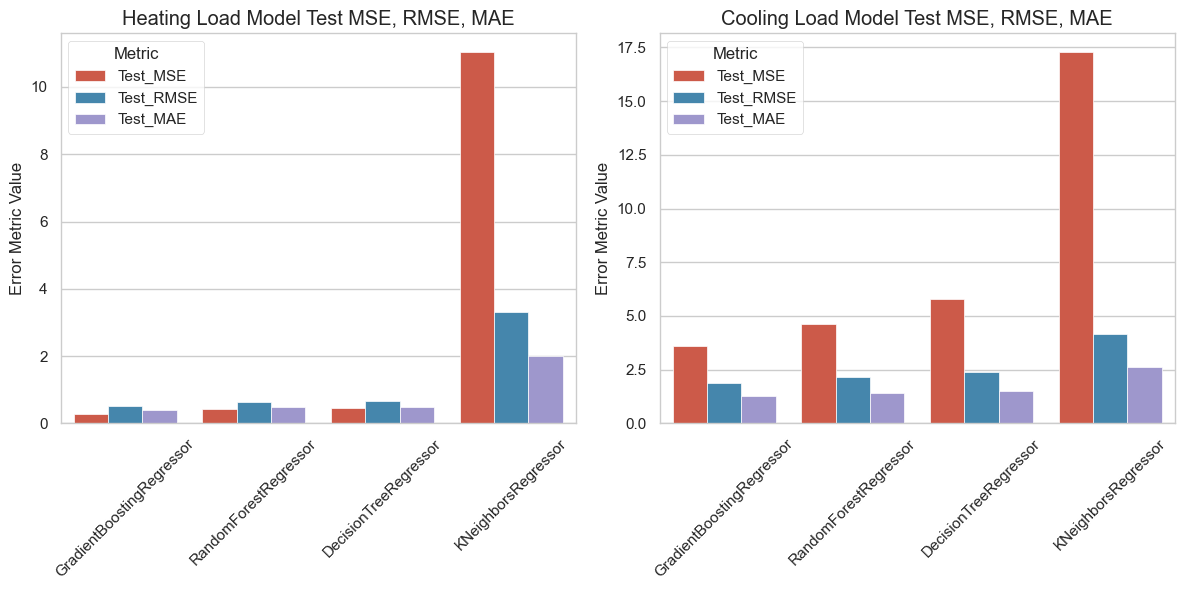

In [37]:
# # plot the results of test data
# fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# sns.lineplot(data=df_heating_test, x='Model_Heating', y='Test_MSE', label='MSE', ax=ax[0])
# sns.lineplot(data=df_heating_test, x='Model_Heating', y='Test_RMSE', label='RMSE', ax=ax[0])
# sns.lineplot(data=df_heating_test, x='Model_Heating', y='Test_MAE', label='MAE', ax=ax[0])
# ax[0].set_xlabel('')
# ax[0].set_ylabel('')
# ax[0].set_xticklabels(labels=df_heating_test['Model_Heating'], rotation=45)
# ax[0].set_title('Heating Load Model Test MSE, RMSE, MAE')

# sns.lineplot(data=df_cooling_test, x='Model_Cooling', y='Test_MSE', label='MSE', ax=ax[1])
# sns.lineplot(data=df_cooling_test, x='Model_Cooling', y='Test_RMSE', label='RMSE', ax=ax[1])
# sns.lineplot(data=df_cooling_test, x='Model_Cooling', y='Test_MAE', label='MAE', ax=ax[1])
# ax[1].set_xlabel('')
# ax[1].set_ylabel('')
# ax[1].set_xticklabels(labels=df_cooling_test['Model_Cooling'], rotation=45)
# ax[1].set_title('Cooling Load Model Test MSE, RMSE, MAE')

# plt.tight_layout()
# plt.show()

# Melt the test data into long format for easier plotting with barplot
df_heating_test_melted = df_heating_test.melt(id_vars='Model_Heating', value_vars=['Test_MSE', 'Test_RMSE', 'Test_MAE'], 
                                              var_name='Metric', value_name='Value')
df_cooling_test_melted = df_cooling_test.melt(id_vars='Model_Cooling', value_vars=['Test_MSE', 'Test_RMSE', 'Test_MAE'], 
                                              var_name='Metric', value_name='Value')

# Plot the results using bar charts
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Heating Load Model Test MSE, RMSE, MAE
sns.barplot(data=df_heating_test_melted, x='Model_Heating', y='Value', hue='Metric', ax=ax[0])
ax[0].set_xticklabels(labels=df_heating_test['Model_Heating'], rotation=45)
ax[0].set_xlabel('')
ax[0].set_ylabel('Error Metric Value')
ax[0].set_title('Heating Load Model Test MSE, RMSE, MAE')

# Cooling Load Model Test MSE, RMSE, MAE
sns.barplot(data=df_cooling_test_melted, x='Model_Cooling', y='Value', hue='Metric', ax=ax[1])
ax[1].set_xticklabels(labels=df_cooling_test['Model_Cooling'], rotation=45)
ax[1].set_xlabel('')
ax[1].set_ylabel('Error Metric Value')
ax[1].set_title('Cooling Load Model Test MSE, RMSE, MAE')

plt.tight_layout()
plt.show()

In [36]:
# check the results of test data
print(f'Heating load model test results: \n{df_heating_test.round(4)}')
print(' ')
print(f'Cooling load model test results: \n{df_cooling_test.round(4)}')

Heating load model test results: 
               Model_Heating  Test_Adj_R2  Test_MSE  Test_RMSE  Test_MAE
0  GradientBoostingRegressor       0.9971    0.2758     0.5252    0.3933
1      RandomForestRegressor       0.9957    0.4154     0.6446    0.4853
2      DecisionTreeRegressor       0.9954    0.4430     0.6656    0.4943
3        KNeighborsRegressor       0.8849   11.0415     3.3229    2.0159
 
Cooling load model test results: 
               Model_Cooling  Test_Adj_R2  Test_MSE  Test_RMSE  Test_MAE
0  GradientBoostingRegressor       0.9593    3.6146     1.9012    1.2925
1      RandomForestRegressor       0.9479    4.6294     2.1516    1.4122
2      DecisionTreeRegressor       0.9350    5.7767     2.4035    1.5225
3        KNeighborsRegressor       0.8054   17.2886     4.1580    2.6253


* On the test data set, Gradient Boosting, Decision Tree and Random Forest still have excellent performance, while K-Nearest Neighbors has worse performance compared to the cross-validation result, indicating a potential overfitting problem of the KNN model. 
* In conclusion, the tree-based models outperform the linear models on this dataset due to the non-linear relationships between the features and the target variables.

##  6. Model Parameter tuning

Boosting machine learning algorithms are highly used because they give better accuracy over simple ones. Performance of these algorithms depends on hyperparameters. An optimal set of parameters can help to achieve higher accuracy. Finding hyperparameters manually is tedious and computationally expensive. Therefore, automation of hyperparameters tuning is important. RandomSearch, GridSearchCV, and Bayesian optimization are generally used to optimize hyperparameters.

In this Notebook, we calculate the best parameters for the model using “GridSearchCV”.

### Decision Tree Tuning

The Decision Tree algorithm has become one of the most widely used machine learning algorithms in various contexts, including competitions like Kaggle and in business environments. Decision Trees can be applied in both classification and regression problems. The model is based on decision rules extracted from the training data. In regression problems, the model uses the predicted value instead of a class label, and the mean squared error (MSE) is often used to evaluate the accuracy of these predictions. 

However, Decision Trees can suffer from issues with generalization and are sensitive to changes in the training data. Even small variations in the training dataset can significantly affect the model's predictive accuracy, making it crucial to carefully tune the hyperparameters for optimal performance.

#### Parameters

- **max_features**: The number of randomly chosen features from which to pick the best feature to split on at each tree node. This can be an integer or one of the following methods:
  - `auto`: Square root of the total number of predictors.
  - `max`: The total number of predictors.
  
- **max_leaf_nodes**: The maximum number of leaf nodes that a tree can have, specified as an integer between 1 and 1e9, inclusive.

- **max_depth**: The maximum depth for growing each tree, specified as an integer between 1 and 100, inclusive.

- **min_samples_leaf**: The minimum number of samples that each branch must have after splitting a node, specified as an integer between 1 and 1e6, inclusive. Any split that causes fewer remaining samples than this number will be discarded.

In [37]:
# Grid Search for Heating Load (y1)
DTR_heating = DecisionTreeRegressor()
param_grid = {
    "criterion": ["squared_error", "absolute_error"],
    "min_samples_split": [14, 15, 16, 17],
    "max_depth": [5, 6, 7],
    "min_samples_leaf": [4, 5, 6],
    "max_leaf_nodes": [29, 30, 31, 32],
}
grid_cv_DTR_heating = GridSearchCV(estimator=DTR_heating, param_grid=param_grid, cv=5, verbose=3)
grid_cv_DTR_heating.fit(X_train, y1_train)

# Output best parameters and score for heating
print("Heating R-Squared: {}".format(grid_cv_DTR_heating.best_score_))
print("Best Hyperparameters for Heating:\n{}".format(grid_cv_DTR_heating.best_params_))

# Evaluate on test set for heating load
best_DTR_heating = grid_cv_DTR_heating.best_estimator_
print("R-Squared on test dataset for Heating: {:.4f}".format(best_DTR_heating.score(X_test, y1_test)))

# Grid Search for Cooling Load (y2)
DTR_cooling = DecisionTreeRegressor()
grid_cv_DTR_cooling = GridSearchCV(estimator=DTR_cooling, param_grid=param_grid, cv=5)
grid_cv_DTR_cooling.fit(X_train, y2_train)

# Output best parameters and score for cooling
print("Cooling R-Squared: {}".format(grid_cv_DTR_cooling.best_score_))
print("Best Hyperparameters for Cooling:\n{}".format(grid_cv_DTR_cooling.best_params_))

# Evaluate on test set for cooling load
best_DTR_cooling = grid_cv_DTR_cooling.best_estimator_
print("R-Squared on test dataset for Cooling: {:.4f}".format(best_DTR_cooling.score(X_test, y2_test)))

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV 1/5] END criterion=squared_error, max_depth=5, max_leaf_nodes=29, min_samples_leaf=4, min_samples_split=14;, score=0.989 total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=5, max_leaf_nodes=29, min_samples_leaf=4, min_samples_split=14;, score=0.987 total time=   0.0s
[CV 3/5] END criterion=squared_error, max_depth=5, max_leaf_nodes=29, min_samples_leaf=4, min_samples_split=14;, score=0.987 total time=   0.0s
[CV 4/5] END criterion=squared_error, max_depth=5, max_leaf_nodes=29, min_samples_leaf=4, min_samples_split=14;, score=0.978 total time=   0.0s
[CV 5/5] END criterion=squared_error, max_depth=5, max_leaf_nodes=29, min_samples_leaf=4, min_samples_split=14;, score=0.987 total time=   0.0s
[CV 1/5] END criterion=squared_error, max_depth=5, max_leaf_nodes=29, min_samples_leaf=4, min_samples_split=15;, score=0.989 total time=   0.0s
[CV 2/5] END criterion=squared_error, max_depth=5, max_leaf_nodes=29, mi

We can clearly see the fine tuned cooling r squared of the Desicion tree has be improved but not eh Heating, it actually went down slightly


## B. Tune Random Forests Parameters
Random forest is an ensemble tool which takes a subset of observations and a subset of variables to build a decision trees. It builds multiple such decision tree and amalgamate them together to get a more accurate and stable prediction. We generally see a random forest as a black box which takes in input and gives out predictions, without worrying too much about what calculations are going on the back end. This black box itself have a few levers we can play with. Each of these levers have some effect on either the performance of the model or the resource – time balance. Parameters in random forest are either to increase the predictive power of the model or to make it easier to train the model.

There are primarily 3 features which can be tuned to improve the predictive power of the model :

Max_features: These are the maximum number of features Random Forest is allowed to try in individual tree. Increasing max_features generally improves the performance of the model as at each node now we have a higher number of options to be considered. However, this is not necessarily true as this decreases the diversity of individual tree which is the USP of random forest. But, for sure, you decrease the speed of algorithm by increasing the max_features. Hence, you need to strike the right balance and choose the optimal max_features.

n_estimators : This is the number of trees you want to build before taking the maximum voting or averages of predictions. Higher number of trees give you better performance but makes your code slower. You should choose as high value as your processor can handle because this makes your predictions stronger and more stable.

min_sample_leaf : If you have built a decision tree before, you can appreciate the importance of minimum sample leaf size. Leaf is the end node of a decision tree. A smaller leaf makes the model more prone to capturing noise in train data. Generally I prefer a minimum leaf size of more than 50. However, you should try multiple leaf sizes to find the most optimum for your use case.

There are a few attributes which have a direct impact on model training speed. In this Notebook, we just mention about the n_jobs parameter. This parameter tells the engine how many processors is it allowed to use. A value of “-1” means there is no restriction whereas a value of “1” means it can only use one processor.

In [38]:
from sklearn.ensemble import RandomForestRegressor

# Grid Search for Heating Load (y1)
RFR_heating = RandomForestRegressor()
param_grid_rfr = {
    "n_estimators": [100, 200, 300],
    "max_features": ["auto", "sqrt", "log2"],
    "max_depth": [10, 20, 30, None],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
grid_cv_RFR_heating = GridSearchCV(estimator=RFR_heating, param_grid=param_grid_rfr, cv=5, verbose=3)
grid_cv_RFR_heating.fit(X_train, y1_train)

# Output best parameters and score for heating
print("Heating R-Squared for Random Forest: {}".format(grid_cv_RFR_heating.best_score_))
print("Best Hyperparameters for Heating (Random Forest):\n{}".format(grid_cv_RFR_heating.best_params_))

# Evaluate on test set for heating load
best_RFR_heating = grid_cv_RFR_heating.best_estimator_
print("R-Squared on test dataset for Heating (Random Forest): {:.4f}".format(best_RFR_heating.score(X_test, y1_test)))

# Grid Search for Cooling Load (y2)
grid_cv_RFR_cooling = GridSearchCV(estimator=RFR_heating, param_grid=param_grid_rfr, cv=5)
grid_cv_RFR_cooling.fit(X_train, y2_train)

# Output best parameters and score for cooling
print("Cooling R-Squared for Random Forest: {}".format(grid_cv_RFR_cooling.best_score_))
print("Best Hyperparameters for Cooling (Random Forest):\n{}".format(grid_cv_RFR_cooling.best_params_))

# Evaluate on test set for cooling load
best_RFR_cooling = grid_cv_RFR_cooling.best_estimator_
print("R-Squared on test dataset for Cooling (Random Forest): {:.4f}".format(best_RFR_cooling.score(X_test, y2_test)))

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV 1/5] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 2/5] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 3/5] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 4/5] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 5/5] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=nan total time=   0.0s
[CV 1/5] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=nan total time=   0.0s
[CV 2/5] END max_depth=10, max_features=auto, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=nan total time

It has improved slightly

## C. Gradient Boosting Regression - Hyperparameter Tuning
What we will do now is make an instance of the GradientBoostingRegressor. We will create our grid with the various values for the hyperparameters. We will then take this grid and place it inside GridSearchCV function so that we can prepare to run our model. There are some arguments that need to be set inside the GridSearchCV function such as estimator, grid, cv, etc.

With this tuning we can see that the mean squared error is lower than with the baseline model. We can now move to the final step of taking these hyperparameter settings and see how they do on the dataset. There are several hyperparameters we need to tune, and they are as follows:

Learning rate: The learning rate is the weight that each tree has on the final prediction.
Number of estimators: The number of estimators is show many trees to create. The more trees the more likely to overfit.
Min samples split: The minimum number of samples required to split an internal node
Max depth: Maximum depth of the individual regression estimators. The maximum depth limits the number of nodes in the tree. Tune this parameter for best performance; the best value depends on the interaction of the input variables.
Subsample: Subsample is the proportion of the sample to use.

In [39]:


# Grid Search for Heating Load (y1)
GBR_heating = GradientBoostingRegressor()
param_grid_gbr = {
    "n_estimators": [100, 200, 300],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 4, 5],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}
grid_cv_GBR_heating = GridSearchCV(estimator=GBR_heating, param_grid=param_grid_gbr, cv=5, verbose=3)
grid_cv_GBR_heating.fit(X_train, y1_train)

# Output best parameters and score for heating
print("Heating R-Squared for Gradient Boosting: {}".format(grid_cv_GBR_heating.best_score_))
print("Best Hyperparameters for Heating (Gradient Boosting):\n{}".format(grid_cv_GBR_heating.best_params_))

# Evaluate on test set for heating load
best_GBR_heating = grid_cv_GBR_heating.best_estimator_
print("R-Squared on test dataset for Heating (Gradient Boosting): {:.4f}".format(best_GBR_heating.score(X_test, y1_test)))

# Grid Search for Cooling Load (y2)
grid_cv_GBR_cooling = GridSearchCV(estimator=GBR_heating, param_grid=param_grid_gbr, cv=5)
grid_cv_GBR_cooling.fit(X_train, y2_train)

# Output best parameters and score for cooling
print("Cooling R-Squared for Gradient Boosting: {}".format(grid_cv_GBR_cooling.best_score_))
print("Best Hyperparameters for Cooling (Gradient Boosting):\n{}".format(grid_cv_GBR_cooling.best_params_))

# Evaluate on test set for cooling load
best_GBR_cooling = grid_cv_GBR_cooling.best_estimator_
print("R-Squared on test dataset for Cooling (Gradient Boosting): {:.4f}".format(best_GBR_cooling.score(X_test, y2_test)))

Fitting 5 folds for each of 243 candidates, totalling 1215 fits
[CV 1/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.825 total time=   0.0s
[CV 2/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.839 total time=   0.0s
[CV 3/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.825 total time=   0.0s
[CV 4/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.823 total time=   0.0s
[CV 5/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100;, score=0.822 total time=   0.0s
[CV 1/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.950 total time=   0.1s
[CV 2/5] END learning_rate=0.01, max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=200;, score=0.

In [40]:
Acc1 = pd.DataFrame(index=None, columns=['model','train_Heating','test_Heating','train_Cooling','test_Cooling'])

In [41]:
# Define your regressors and their hyperparameters
regressors = {
    'DecisionTreeRegressor': (
        DecisionTreeRegressor(),
        {
            'max_depth': [7],
            'max_leaf_nodes': [31, 30],
            'min_samples_leaf': [4, 6],
            'min_samples_split': [14]
        }
    ),
    'RandomForestRegressor': (
        RandomForestRegressor(),
        {
            'n_estimators': [300],
            'max_features': ['log2', 'sqrt'],
            'max_depth': [20, 30],
            'min_samples_leaf': [1],
            'min_samples_split': [2, 10]
        }
    ),
    'GradientBoostingRegressor': (
        GradientBoostingRegressor(),
        {
            'learning_rate': [0.1],
            'n_estimators': [100, 300],
            'max_depth': [3],
            'min_samples_leaf': [1, 4],
            'min_samples_split': [2, 10]
        }
    )

}



In [42]:
# DataFrame to store the results
results = pd.DataFrame(columns=['Model', 'Train_Heating_R2', 'Test_Heating_R2', 'Train_Cooling_R2', 'Test_Cooling_R2', 'Best_Params'])

# Dictionary to store the best models and their predictions
best_models = {}

def perform_grid_search(model, params, X_train, y_train, X_test, y_test):
    grid_search = GridSearchCV(estimator=model, param_grid=params, cv=5, n_jobs=-1, verbose=0)
    grid_search.fit(X_train, y_train)
    
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_test)
    
    train_r2 = grid_search.best_score_
    test_r2 = best_model.score(X_test, y_test)
    
    return best_model, y_pred, train_r2, test_r2, grid_search.best_params_

for model_name, (model, params) in regressors.items():
    # Perform grid search for heating
    best_heating_model, y1_pred, train_heating_r2, test_heating_r2, best_params_heating = perform_grid_search(model, params, X_train, y1_train, X_test, y1_test)
    
    # Perform grid search for cooling
    best_cooling_model, y2_pred, train_cooling_r2, test_cooling_r2, best_params_cooling = perform_grid_search(model, params, X_train, y2_train, X_test, y2_test)
    
    # Store the best models and predictions
    best_models[model_name] = {
        'best_heating_model': best_heating_model,
        'best_cooling_model': best_cooling_model,
        'y1_pred': y1_pred,
        'y2_pred': y2_pred
    }
    
    # Create a DataFrame for the current results and concatenate with the main results DataFrame
    current_result = pd.DataFrame({
        'Model': [model_name],
        'Train_Heating_R2': [train_heating_r2],
        'Test_Heating_R2': [test_heating_r2],
        'Train_Cooling_R2': [train_cooling_r2],
        'Test_Cooling_R2': [test_cooling_r2],
        'Best_Params': [best_params_cooling]  # Could store best_params_heating as well if needed
    })
    
    results = pd.concat([results, current_result], ignore_index=True)

# Display the results DataFrame
print(results.to_string(index=False))



                    Model  Train_Heating_R2  Test_Heating_R2  Train_Cooling_R2  Test_Cooling_R2                                                                                                    Best_Params
    DecisionTreeRegressor          0.993342         0.995132          0.962831         0.961924                         {'max_depth': 7, 'max_leaf_nodes': 30, 'min_samples_leaf': 6, 'min_samples_split': 14}
    RandomForestRegressor          0.995003         0.995463          0.965782         0.953743 {'max_depth': 20, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
GradientBoostingRegressor          0.997343         0.997235          0.970213         0.961216     {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}


The GradientBosstinfRegressor still is this the best performed

Best model: GradientBoostingRegressor
Heating R2 score: 0.997234996029528
Cooling R2 score: 0.9612159357998141


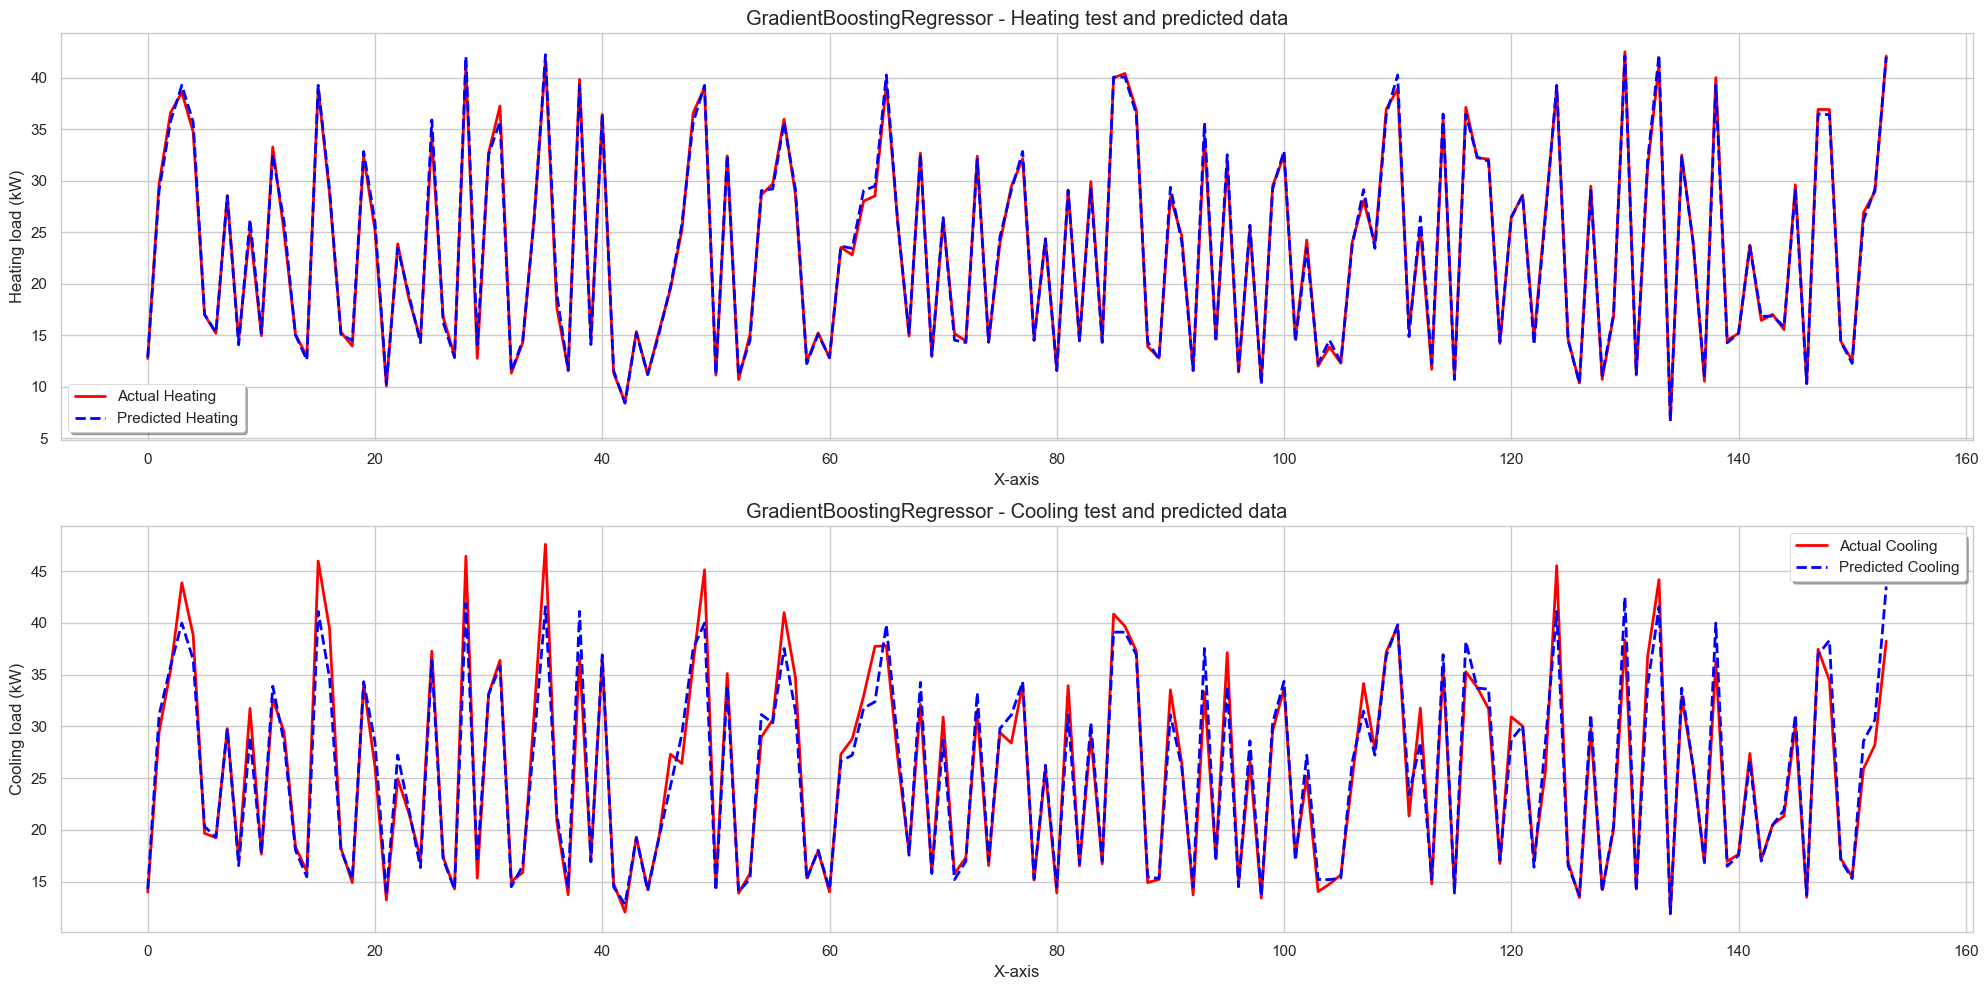

In [43]:
# Step 1: Identify the best model based on the average R2 score
best_model_name = results.loc[(results['Test_Heating_R2'] + results['Test_Cooling_R2']).idxmax(), 'Model']

# Get the individual R² scores for heating and cooling for the best model
best_heating_r2_score = results.loc[(results['Test_Heating_R2'] + results['Test_Cooling_R2']).idxmax(), 'Test_Heating_R2']
best_cooling_r2_score = results.loc[(results['Test_Heating_R2'] + results['Test_Cooling_R2']).idxmax(), 'Test_Cooling_R2']

# Print out both R² scores
print(f"Best model: {best_model_name}")
print(f"Heating R2 score: {best_heating_r2_score}")
print(f"Cooling R2 score: {best_cooling_r2_score}")

# Step 2: Plot the results for the best model
import matplotlib.pyplot as plt

if best_model_name in best_models:
    x_ax = range(len(y1_test))
    
    plt.figure(figsize=(20, 10))
    
    # Plot for Heating
    plt.subplot(2, 1, 1)
    plt.plot(x_ax, y1_test, label="Actual Heating", color='red', linewidth=2)
    plt.plot(x_ax, best_models[best_model_name]['y1_pred'], label="Predicted Heating", color='blue', linestyle='--', linewidth=2)
    plt.title(f"{best_model_name} - Heating test and predicted data")
    plt.xlabel('X-axis')
    plt.ylabel('Heating load (kW)')
    plt.legend(loc='best', fancybox=True, shadow=True)
    plt.grid(True)
    
    # Plot for Cooling
    plt.subplot(2, 1, 2)
    plt.plot(x_ax, y2_test, label="Actual Cooling", color='red', linewidth=2)
    plt.plot(x_ax, best_models[best_model_name]['y2_pred'], label="Predicted Cooling", color='blue', linestyle='--', linewidth=2)
    plt.title(f"{best_model_name} - Cooling test and predicted data")
    plt.xlabel('X-axis')
    plt.ylabel('Cooling load (kW)')
    plt.legend(loc='best', fancybox=True, shadow=True)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
else:
    print(f"The best model {best_model_name} was not found in the best_models dictionary.")

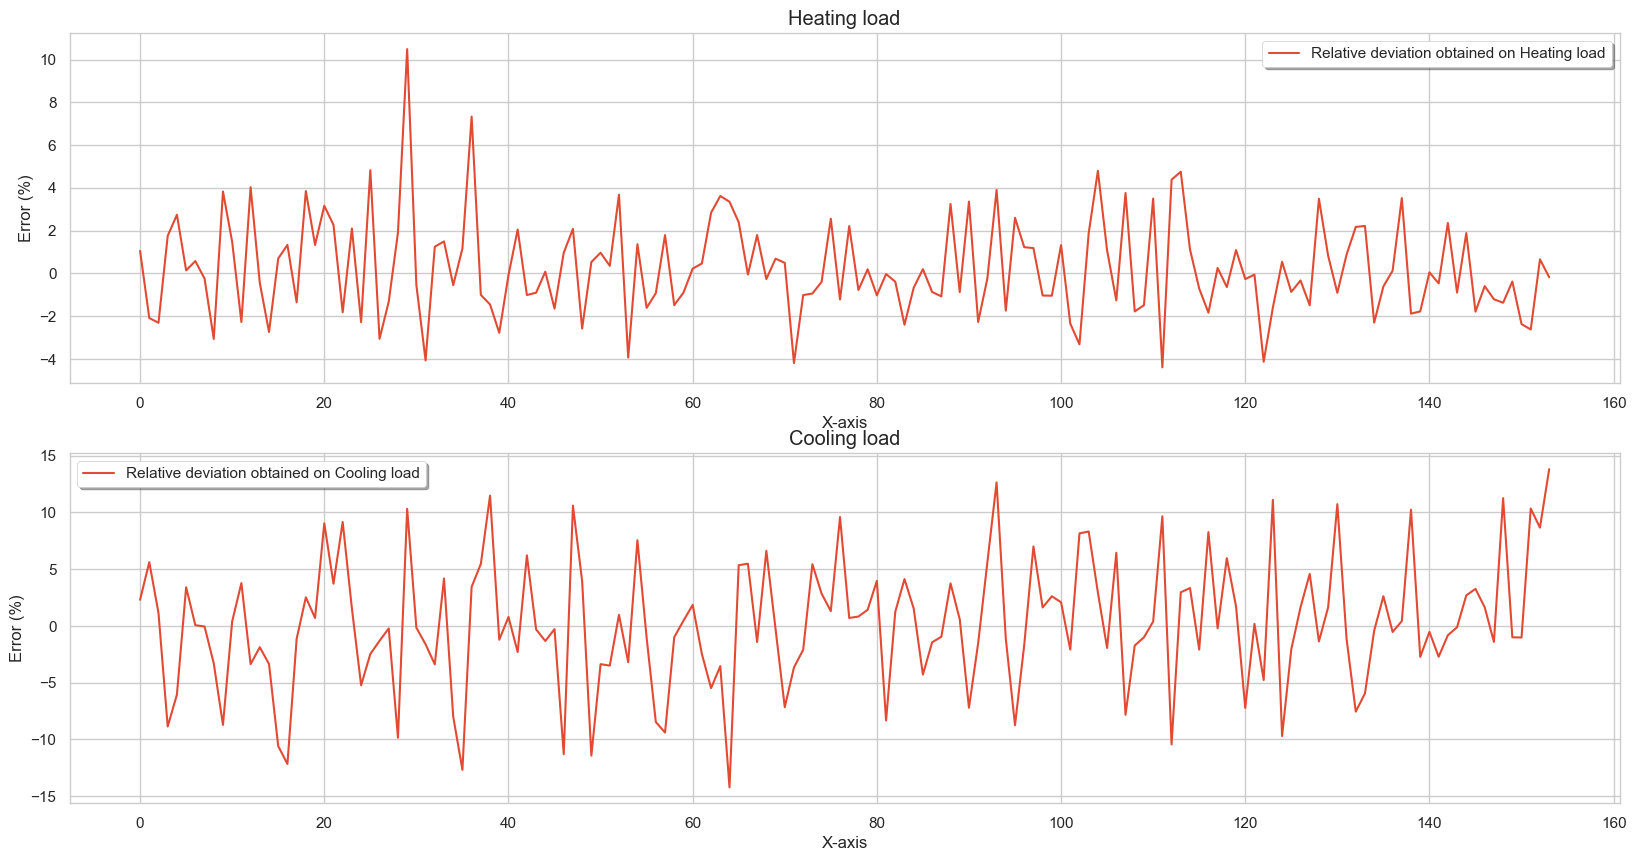

In [44]:
def AAD(y1_test, y1_pred):
    AAD =[]
    for i in range(len(y1_pred)):
        AAD.append((y1_pred[i] - y1_test.values[i])/y1_test.values[i]*100)
    return AAD

x_ax = range(len(y1_test))
plt.figure(figsize=(20,10))
plt.subplot(2,1,1)
plt.plot(x_ax, AAD(y1_test, y1_pred), label="Relative deviation obtained on Heating load")
plt.title("Heating load")
plt.xlabel('X-axis')
plt.ylabel('Error (%)')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)

plt.subplot(2,1,2)
plt.plot(x_ax, AAD(y2_test, y2_pred), label="Relative deviation obtained on Cooling load")
plt.title("Cooling load")
plt.xlabel('X-axis')
plt.ylabel('Error (%)')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)

plt.show()

## 6. Performance

* When predicting the heating load, the expected error is 0.3933 unit on average, and when predicting the cooling load, the expected error of is 1.2925 unit on average.
* These features of a residential building are more useful in predicting the heating load, with the error percentage of 1.7632%, while when in predicting the cooling load, the error percentage is 5.2567%
* Professionals with domain knowledge can determine if the error percentages are within an acceptable range.

Next, I will extract the feature importance from the tree models to see which features have the most influence on the energy efficiency.

In [45]:
from joblib import dump
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor


def select_and_save_best_model(results_df, model_list, metric='Test_MSE', model_type='Heating', save_dir='/path/to/save/directory', X=None, y=None):
    # Find the index of the model with the lowest metric value
    best_model_index = results_df[metric].idxmin()
    best_model_name = results_df.loc[best_model_index, f'Model_{model_type}']
    
    print(f"Best {model_type} model based on {metric}: {best_model_name}")
    
    # Retrieve the best model
    best_model = None
    for model in model_list:
        if model.__class__.__name__ == best_model_name:
            best_model = model
            break
    
    # Perform grid search if the best model is GradientBoostingRegressor
    if best_model is not None and best_model_name == 'GradientBoostingRegressor':
        # Define your hyperparameters for grid search
        params = {
            'learning_rate': [0.05, 0.1, 0.2],
            'n_estimators': [100, 300],
            'max_depth': [3, 5],
            'min_samples_leaf': [1, 2],
            'min_samples_split': [2, 5]
        }
        
        # Perform train-test split
        X_train, X_test, y_train, y_test = train_test_split(X, y1 if model_type == 'Heating' else y2, test_size=0.2, random_state=42)
        
        # Perform grid search
        grid_search = GridSearchCV(estimator=best_model, param_grid=params, cv=5, n_jobs=-1, verbose=1)
        grid_search.fit(X_train, y_train)
        
        # Retrieve the best estimator from grid search
        best_model = grid_search.best_estimator_
        print(f"Best hyperparameters found: {grid_search.best_params_}")
    
    # Train the best model on the full training data and save
    if best_model is not None:
        best_model.fit(X_train, y_train)
        
        # Save the best model to the specified directory
        model_path = os.path.join(save_dir, f'model_{model_type.lower()}_corrected.joblib')
        dump(best_model, model_path)
        print(f"Best {model_type} model ({best_model_name}) saved to {model_path}")
    else:
        print(f"No model found for {model_type}.")

# Example usage with modified function
select_and_save_best_model(results_df=df_heating_test, model_list=models, metric='Test_MSE', model_type='Heating', save_dir='/Users/jiaxinhe/Desktop/IXN/TF2DeepFloorplan/EnergyEfficiencyPrediction', X=X, y=y1)
select_and_save_best_model(results_df=df_cooling_test, model_list=models, metric='Test_MSE', model_type='Cooling', save_dir='/Users/jiaxinhe/Desktop/IXN/TF2DeepFloorplan/EnergyEfficiencyPrediction', X=X, y=y2)

Best Heating model based on Test_MSE: GradientBoostingRegressor
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best hyperparameters found: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Best Heating model (GradientBoostingRegressor) saved to /Users/jiaxinhe/Desktop/IXN/TF2DeepFloorplan/EnergyEfficiencyPrediction/model_heating_corrected.joblib
Best Cooling model based on Test_MSE: GradientBoostingRegressor
Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best hyperparameters found: {'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}
Best Cooling model (GradientBoostingRegressor) saved to /Users/jiaxinhe/Desktop/IXN/TF2DeepFloorplan/EnergyEfficiencyPrediction/model_cooling_corrected.joblib


In [46]:
from joblib import load
# Define your seed for reproducibility
seed = 42

# Load or fit the models using the whole dataset
model_path_heating = '/Users/jiaxinhe/Desktop/IXN/TF2DeepFloorplan/EnergyEfficiencyPrediction/model_cooling_corrected.joblib'
model_path_cooling = '/Users/jiaxinhe/Desktop/IXN/TF2DeepFloorplan/EnergyEfficiencyPrediction/model_heating_corrected.joblib'

if os.path.exists(model_path_heating):
    gb_heating = load(model_path_heating)
    print(f"Loaded heating model from {model_path_heating}")
else:
    gb_heating = GradientBoostingRegressor(random_state=seed).fit(X=X, y=y1)
    print("Trained new heating model")
    
if os.path.exists(model_path_cooling):
    gb_cooling = load(model_path_cooling)
    print(f"Loaded cooling model from {model_path_cooling}")
else:
    gb_cooling = GradientBoostingRegressor(random_state=seed).fit(X=X, y=y2)
    print("Trained new cooling model")

# Extract the feature importance
heating_feature_importance = pd.DataFrame(data={'Feature': X.columns, 'Importance': gb_heating.feature_importances_})
cooling_feature_importance = pd.DataFrame(data={'Feature': X.columns, 'Importance': gb_cooling.feature_importances_})

# Sort the feature importance in descending order
heating_feature_importance = heating_feature_importance.sort_values(by='Importance', ascending=False).reset_index(drop=True)
cooling_feature_importance = cooling_feature_importance.sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Print the sorted feature importances
print("Heating Feature Importance:\n", heating_feature_importance)
print("\nCooling Feature Importance:\n", cooling_feature_importance)

Loaded heating model from /Users/jiaxinhe/Desktop/IXN/TF2DeepFloorplan/EnergyEfficiencyPrediction/model_cooling_corrected.joblib
Loaded cooling model from /Users/jiaxinhe/Desktop/IXN/TF2DeepFloorplan/EnergyEfficiencyPrediction/model_heating_corrected.joblib
Heating Feature Importance:
                      Feature  Importance
0       relative_compactness    0.335240
1             overall_height    0.303898
2                  roof_area    0.233114
3                  wall_area    0.076013
4               glazing_area    0.045956
5  glazing_area_distribution    0.004115
6                orientation    0.001664

Cooling Feature Importance:
                      Feature  Importance
0                  roof_area    0.476910
1       relative_compactness    0.317854
2             overall_height    0.072185
3               glazing_area    0.067155
4                  wall_area    0.043541
5  glazing_area_distribution    0.022207
6                orientation    0.000148


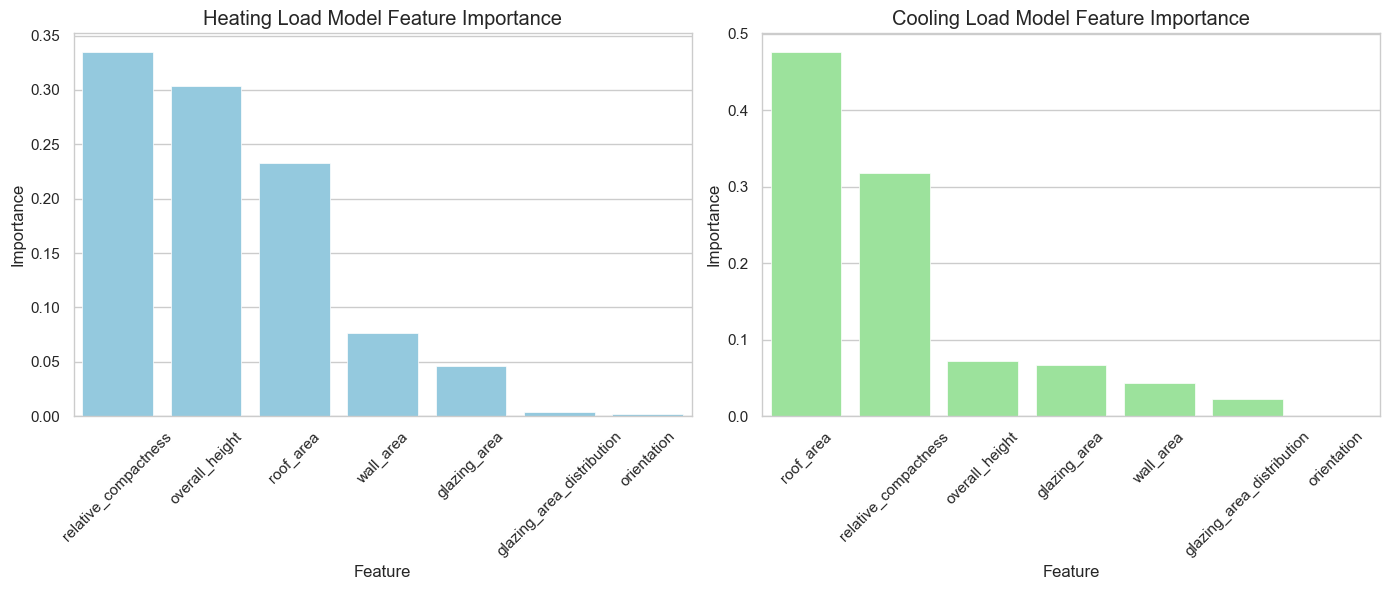

In [47]:
# Plotting the feature importance for heating load

fig, axs = plt.subplots(1, 2, figsize=(14, 6))

# Plotting the feature importance for heating load
sns.barplot(x='Feature', y='Importance', data=heating_feature_importance, ax=axs[0], color='skyblue')
axs[0].set_title('Heating Load Model Feature Importance')
axs[0].set_xlabel('Feature')
axs[0].set_ylabel('Importance')
axs[0].tick_params(axis='x', rotation=45)

# Plotting the feature importance for cooling load
sns.barplot(x='Feature', y='Importance', data=cooling_feature_importance, ax=axs[1], color='lightgreen')
axs[1].set_title('Cooling Load Model Feature Importance')
axs[1].set_xlabel('Feature')
axs[1].set_ylabel('Importance')
axs[1].tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [48]:
# Load the best models
heating_model_path = '/Users/jiaxinhe/Desktop/IXN/TF2DeepFloorplan/EnergyEfficiencyPrediction/model_heating_corrected.joblib'
model_heating = load(heating_model_path)

cooling_model_path = '/Users/jiaxinhe/Desktop/IXN/TF2DeepFloorplan/EnergyEfficiencyPrediction/model_cooling_corrected.joblib'
model_cooling = load(cooling_model_path)

# Load your dataset
data = pd.read_csv('/Users/jiaxinhe/Desktop/IXN/TF2DeepFloorplan/EnergyEfficiencyPrediction/ENB2012_data.csv')
data.columns = ['relative_compactness', 'wall_area', 'roof_area', 'overall_height', 'orientation',
                'glazing_area', 'glazing_area_distribution', 'heating_load', 'cooling_load']

# Select features and target variable
X = data[['relative_compactness', 'wall_area', 'roof_area', 'overall_height', 'orientation', 'glazing_area', 'glazing_area_distribution']]
y1 = data['heating_load']
y2 = data['cooling_load']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y1, test_size=0.2, random_state=42)
X_train_cooling, X_test_cooling, y_train_cooling, y_test_cooling = train_test_split(X, y2, test_size=0.2, random_state=42)

# Make predictions using the heating model
y_pred_heating = model_heating.predict(X_test)

# Make predictions using the cooling model
y_pred_cooling = model_cooling.predict(X_test_cooling)

# Evaluate heating model performance
mae_heating = mean_absolute_error(y_test, y_pred_heating)
mse_heating = mean_squared_error(y_test, y_pred_heating)
r2_heating = r2_score(y_test, y_pred_heating)

# Evaluate cooling model performance
mae_cooling = mean_absolute_error(y_test_cooling, y_pred_cooling)
mse_cooling = mean_squared_error(y_test_cooling, y_pred_cooling)
r2_cooling = r2_score(y_test_cooling, y_pred_cooling)

# Calculate average heating load value
heating_avg_value = np.mean(y1).round(4)

# Calculate model prediction error for heating load (MAE over entire dataset)
heating_prediction_error = np.mean(np.abs(y1 - model_heating.predict(X))).round(4)

# Calculate the error percentage for heating load
heating_error_percent = (heating_prediction_error / heating_avg_value * 100).round(4)

# Print the heating load statistics
print(f"\nHeating load average value: {heating_avg_value}")
print(f"Heating load model prediction error: {heating_prediction_error}")
print(f"Error %: {heating_error_percent}%")

# Calculate average cooling load value
cooling_avg_value = np.mean(y2).round(4)

# Calculate model prediction error for cooling load (MAE over entire dataset)
cooling_prediction_error = np.mean(np.abs(y2 - model_cooling.predict(X))).round(4)

# Calculate the error percentage for cooling load
cooling_error_percent = (cooling_prediction_error / cooling_avg_value * 100).round(4)

# Print the cooling load statistics
print(f"\nCooling load average value: {cooling_avg_value}")
print(f"Cooling load model prediction error: {cooling_prediction_error}")
print(f"Error %: {cooling_error_percent}%")

# Print the input value and the output prediction for the first row
first_row = X.iloc[0].values.reshape(1, -1)
heating_prediction = model_heating.predict(first_row)
cooling_prediction = model_cooling.predict(first_row)

# Calculate predictions for the entire dataset and compare them with actual values
all_y_pred_heating = model_heating.predict(X)
all_y_pred_cooling = model_cooling.predict(X)

# Add predictions to the dataframe
data['predicted_heating_load'] = all_y_pred_heating
data['predicted_cooling_load'] = all_y_pred_cooling

print("\nComparison of actual and predicted heating loads for the entire dataset:")
print(data[['heating_load', 'predicted_heating_load']].head())

print("\nComparison of actual and predicted cooling loads for the entire dataset:")
print(data[['cooling_load', 'predicted_cooling_load']].head())


Heating load average value: 22.3072
Heating load model prediction error: 0.3137
Error %: 1.4063%

Cooling load average value: 24.5878
Cooling load model prediction error: 0.9901
Error %: 4.0268%

Comparison of actual and predicted heating loads for the entire dataset:
   heating_load  predicted_heating_load
0         15.55               15.580677
1         15.55               15.642939
2         15.55               15.441438
3         15.55               15.422610
4         20.84               20.933136

Comparison of actual and predicted cooling loads for the entire dataset:
   cooling_load  predicted_cooling_load
0         21.33               21.725979
1         21.33               20.709246
2         21.33               20.709246
3         21.33               22.500237
4         28.28               27.281348
